In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import seaborn as sns
import sys
import time 
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [5]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

# Analyse de fond : 

## Création de la variable BuildingAge : 

In [6]:
from datetime import datetime
current_year = datetime.now().year
df['BuildingAge'] = current_year - df['YearBuilt']

In [7]:
df[["BuildingAge", "DataYear", "YearBuilt"]]

BuildingAge  DataYear  YearBuilt
0              96      2016       1927
1              27      2016       1996
2              54      2016       1969
3              97      2016       1926
4              43      2016       1980
...           ...       ...        ...
3371           33      2016       1990
3372           19      2016       2004
3373           49      2016       1974
3374           34      2016       1989
3375           85      2016       1938

[3376 rows x 3 columns]

In [8]:
df.drop(columns = "YearBuilt", inplace = True )

## Corréction nombe de batiment : 

In [9]:
df.NumberofBuildings.unique()

array([  1.,   3.,   0.,   2.,   4.,  27.,   6.,  11.,  14.,   9.,   5.,
        nan,   7.,   8.,  16.,  23.,  10., 111.])

In [10]:
df.NumberofBuildings.value_counts(ascending= False)

1.0      3175
0.0        92
2.0        37
3.0        22
4.0        12
5.0        10
6.0         5
8.0         3
10.0        2
14.0        2
9.0         2
7.0         1
11.0        1
16.0        1
23.0        1
27.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

Les batiments avec un nombre de batiments à 0 sont impossible. On replacera donc 0 par 1.

In [11]:
df.loc[df.NumberofBuildings == 0.0,"NumberofBuildings"] = 1 
df.NumberofBuildings.fillna(df.NumberofBuildings.median(), inplace = True)

In [12]:
df.shape

(3376, 46)

## Outlier : 

In [13]:
df = df[df['Outlier'] != 'High outlier']
df = df[df['Outlier'] != 'Low outlier']

In [14]:
df = df[df['ComplianceStatus'] != 'Non-Compliant']
df = df[df['ComplianceStatus'] != 'Missing Data']

In [15]:
df.shape

(3322, 46)

## Abirantes : 

In [16]:
# Supprimer les bâtiments ayant des valeurs incohérentes pour les features "SiteEnergyUseWN(kBtu)" et "TotalGHGEmissions"
df = df[(df['SiteEnergyUse(kBtu)'] > 0) & (df['TotalGHGEmissions'] > 0)]

In [17]:
df.shape

(3314, 46)

## Identification des bâtiments destinés à l'habitation

In [18]:
df = df[df['BuildingType'] != 'Multifamily LR (1-4)']
df = df[df['BuildingType'] != 'Multifamily MR (5-9)']
df = df[df['BuildingType'] != 'Multifamily HR (10+)']

In [19]:
df.shape

(1631, 46)

In [20]:
df['Neighborhood'] = df['Neighborhood'].str.upper()

In [21]:
df['Neighborhood'] = df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [22]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        785
SecondLargestPropertyUseTypeGFA     785
ThirdLargestPropertyUseType        1281


## Suppression des variables à faible cardinalité et /ou inutiles

- complianceStatus : Si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours. 92% des données correspondent, il n'y pas d'intérêt à conserver cette variable.
- On ne sais pas à quoi correspond Error - Correct Default Data.
- DefaultData : si un batiment à au moins une valeur par défault dans ses relevés. Il y a 94% de produits qui n'ont pas de valeurs par défault. La quasi totalité des données donc nous pouvons supprimer la variable.
- L'étude se fait sur une ville et donc un seul Etat. Les variables State et City sont donc inutiles.
- Afin de localiser les bâtiments la Longitude et la Latitude seront les données utilisées. On supprime donc l'adresse et le ZipCode.
- CouncilDistrictCode district du bâtiment.La consommation en énergie d'un bâtiment ne peux pas dépendre de son district.

In [23]:
df.drop(columns = ["DataYear","DefaultData","State",
                     "City", "ComplianceStatus",
                     "ZipCode","Address",
                     "CouncilDistrictCode","Outlier"], inplace = True)

In [24]:
df.columns.tolist()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'TaxParcelIdentificationNumber',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge']

Nous avons différentes unités répertoriées :

- kWh : kilowattheure
- Therm : correspond approximativement à l'énergie libérée par la combustion de 2 kg (approx. 3 l) d'essence.
- kBtu : British thermal unit

Nous choississons de travailler avec le kBtu.

Le suffixe WN identifie les valeurs normalisées selon la météo. C'est la consommation d'énergie du site que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. C'est donc déjà une prédiction.

In [25]:
df.drop(columns = ['OSEBuildingID','Electricity(kWh)', 'NaturalGas(therms)',
                   'TaxParcelIdentificationNumber',
                   'SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)',
                   'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity'], inplace = True )

In [26]:
df.reset_index(drop = True, inplace = True)

In [27]:
df.columns.tolist()

['BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Comments',
 'TotalGHGEmissions',
 'BuildingAge']

### Number of Floors

In [28]:
df.NumberofFloors.sort_values(ascending=True).unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 36, 37,
       39, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99])

In [29]:
df[df.NumberofFloors == df.NumberofFloors.max()]

BuildingType PrimaryPropertyType                    PropertyName  \
917  NonResidential    Worship Facility  Seattle Chinese Baptist Church   

         Neighborhood  Latitude  Longitude  NumberofBuildings  NumberofFloors  \
917  GREATER DUWAMISH  47.55072 -122.30265                1.0              99   

     PropertyGFATotal  PropertyGFAParking  ...  ENERGYSTARScore  \
917             21948                   0  ...             80.0   

    SiteEUI(kBtu/sf) SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu) SteamUse(kBtu)  \
917             14.9          46.599998          326001.1875            0.0   

     Electricity(kBtu) NaturalGas(kBtu)  Comments TotalGHGEmissions  \
917           326001.0              0.0       NaN              2.27   

     BuildingAge  
917           46  

[1 rows x 29 columns]

il se trouve que cette église a un étage, c'est donc une erreur

In [30]:
df.NumberofFloors.replace(99,1, inplace = True)

Une rapide vérification nous montre que ces propriétés avec 0 étages sont des erreurs. Nous préférerons la valeur médiane.

In [31]:
floor_median = round(df.NumberofFloors.median(),2)
df.loc[df.NumberofFloors == df.NumberofFloors.min(),'NumberofFloors']= floor_median

In [32]:
df.shape

(1631, 29)

## Valeur manquantes : 

In [34]:
def rapport_valeurs_manquantes(donnees):
    total = donnees.isnull().sum()
    pourcentage = round((total / len(donnees)) * 100, 2)
    
    tableau = pd.concat([total, pourcentage.round(2)], axis=1)
    tableau.columns = ['Total_Valeurs_Absentes', 'Pourcentage_de_Valeurs_Absentes_%']
    affichage = tableau[tableau['Total_Valeurs_Absentes'] != 0]
    affichage_sorted = affichage.sort_values('Pourcentage_de_Valeurs_Absentes_%', ascending=False)
    display(affichage_sorted)
    
rapport_valeurs_manquantes(df)

Total_Valeurs_Absentes  \
Comments                                           1631   
YearsENERGYSTARCertified                           1534   
ThirdLargestPropertyUseType                        1281   
ThirdLargestPropertyUseTypeGFA                     1281   
SecondLargestPropertyUseType                        785   
SecondLargestPropertyUseTypeGFA                     785   
ENERGYSTARScore                                     551   
LargestPropertyUseType                                4   
LargestPropertyUseTypeGFA                             4   

                                 Pourcentage_de_Valeurs_Absentes_%  
Comments                                                    100.00  
YearsENERGYSTARCertified                                     94.05  
ThirdLargestPropertyUseType                                  78.54  
ThirdLargestPropertyUseTypeGFA                               78.54  
SecondLargestPropertyUseType                                 48.13  
SecondLargestPropertyUseTypeGFA                              48.13  
ENERGYSTARScore                                              33.78  
LargestPropertyUseType                                        0.25  
LargestPropertyUseTypeGFA                                     0.25

In [35]:
df = df.dropna(subset=['LargestPropertyUseType'])

Conservation des variables avec moins de 90% de valeurs manquantes

In [36]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.9]]

Pour le deuxième et le troisième type d'usage, nous interprétons un Nan comme une absence d'usage. Par conséquent, nous fixons également la surface à 0.

In [37]:
df[['ThirdLargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA']]

ThirdLargestPropertyUseType    SecondLargestPropertyUseType  \
0                            NaN                             NaN   
1                     Restaurant                         Parking   
2                            NaN                             NaN   
3                            NaN                             NaN   
4                  Swimming Pool                         Parking   
...                          ...                             ...   
1626                         NaN                             NaN   
1627                         NaN                             NaN   
1628               Swimming Pool  Fitness Center/Health Club/Gym   
1629          Pre-school/Daycare  Fitness Center/Health Club/Gym   
1630          Pre-school/Daycare  Fitness Center/Health Club/Gym   

      ThirdLargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  
0                                NaN                              NaN  
1                             4622.0                          15064.0  
2                                NaN                              NaN  
3                                NaN                              NaN  
4                                0.0                          68009.0  
...                              ...                              ...  
1626                             NaN                              NaN  
1627                             NaN                              NaN  
1628                             0.0                           5574.0  
1629                           484.0                           6501.0  
1630                          1108.0                           8000.0  

[1627 rows x 4 columns]

In [38]:
df.SecondLargestPropertyUseType = df.SecondLargestPropertyUseType.fillna("nouse")
df.ThirdLargestPropertyUseType = df.ThirdLargestPropertyUseType.fillna("nouse")

In [39]:
df.SecondLargestPropertyUseTypeGFA.fillna(value = 0, inplace =True)
df.ThirdLargestPropertyUseTypeGFA.fillna(value = 0, inplace =True)

In [40]:
df[['ThirdLargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA']]

ThirdLargestPropertyUseType    SecondLargestPropertyUseType  \
0                          nouse                           nouse   
1                     Restaurant                         Parking   
2                          nouse                           nouse   
3                          nouse                           nouse   
4                  Swimming Pool                         Parking   
...                          ...                             ...   
1626                       nouse                           nouse   
1627                       nouse                           nouse   
1628               Swimming Pool  Fitness Center/Health Club/Gym   
1629          Pre-school/Daycare  Fitness Center/Health Club/Gym   
1630          Pre-school/Daycare  Fitness Center/Health Club/Gym   

      ThirdLargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  
0                                0.0                              0.0  
1                             4622.0                          15064.0  
2                                0.0                              0.0  
3                                0.0                              0.0  
4                                0.0                          68009.0  
...                              ...                              ...  
1626                             0.0                              0.0  
1627                             0.0                              0.0  
1628                             0.0                           5574.0  
1629                           484.0                           6501.0  
1630                          1108.0                           8000.0  

[1627 rows x 4 columns]

In [41]:
df.isna().sum()

BuildingType                         0
PrimaryPropertyType                  0
PropertyName                         0
Neighborhood                         0
Latitude                             0
Longitude                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
ListOfAllPropertyUseTypes            0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType          0
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                    549
SiteEUI(kBtu/sf)                     0
SourceEUI(kBtu/sf)                   0
SiteEnergyUse(kBtu)                  0
SteamUse(kBtu)                       0
Electricity(kBtu)                    0
NaturalGas(kBtu)                     0
TotalGHGEmissions        

## Analyse EnergyStarScore : 

on remplace les valeurs manquantes dans la colonne 'ENERGYSTARScore' par la médiane de cette colonne, spécifique à chaque type de bâtiment.

In [42]:
for batCategorie in df['BuildingType'].unique():
    mediane = (df.loc[df['BuildingType']==batCategorie]).loc[:,'ENERGYSTARScore'].median()
    df.loc[((df['ENERGYSTARScore'].isnull()) & (df['BuildingType']==batCategorie)), 'ENERGYSTARScore'] = mediane

on supprime toutes les lignes du DataFrame où la colonne 'BuildingType' a la valeur 'Nonresidential WA'.

In [51]:
masque = df['BuildingType']=='Nonresidential WA'
df = df[~masque]

In [52]:
df.isna().sum()

BuildingType                       0
PrimaryPropertyType                0
PropertyName                       0
Neighborhood                       0
Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
ListOfAllPropertyUseTypes          0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUI(kBtu/sf)                   0
SourceEUI(kBtu/sf)                 0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
Electricity(kBtu)                  0
NaturalGas(kBtu)                   0
TotalGHGEmissions                  0
BuildingAge                        0
d

# Feature engineering et analyse exploratoire

### Statistiques descriptives

In [54]:
df.describe().T

count          mean           std  \
Latitude                         1626.0  4.761593e+01  4.817243e-02   
Longitude                        1626.0 -1.223328e+02  2.446460e-02   
NumberofBuildings                1626.0  1.201722e+00  2.958153e+00   
NumberofFloors                   1626.0  4.119311e+00  6.196617e+00   
PropertyGFATotal                 1626.0  1.194547e+05  2.992991e+05   
PropertyGFAParking               1626.0  1.318906e+04  4.276098e+04   
PropertyGFABuilding(s)           1626.0  1.062657e+05  2.859157e+05   
LargestPropertyUseTypeGFA        1626.0  9.900060e+04  2.785901e+05   
SecondLargestPropertyUseTypeGFA  1626.0  1.885503e+04  5.126493e+04   
ThirdLargestPropertyUseTypeGFA   1626.0  3.218075e+03  1.818781e+04   
ENERGYSTARScore                  1626.0  6.702891e+01  2.325238e+01   
SiteEUI(kBtu/sf)                 1626.0  7.314317e+01  7.378829e+01   
SourceEUI(kBtu/sf)               1626.0  1.784197e+02  1.846459e+02   
SiteEnergyUse(kBtu)              1626.0  8.577264e+06  3.057553e+07   
SteamUse(kBtu)                   1626.0  5.251820e+05  5.580801e+06   
Electricity(kBtu)                1626.0  5.929267e+06  2.101227e+07   
NaturalGas(kBtu)                 1626.0  2.007285e+06  9.480722e+06   
TotalGHGEmissions                1626.0  1.884799e+02  7.607240e+02   
BuildingAge                      1626.0  6.095080e+01  3.266268e+01   

                                         min           25%           50%  \
Latitude                            47.49917  4.758520e+01  4.761235e+01   
Longitude                         -122.41182 -1.223432e+02 -1.223329e+02   
NumberofBuildings                    1.00000  1.000000e+00  1.000000e+00   
NumberofFloors                       1.00000  1.000000e+00  2.000000e+00   
PropertyGFATotal                 11285.00000  2.939550e+04  4.915450e+04   
PropertyGFAParking                   0.00000  0.000000e+00  0.000000e+00   
PropertyGFABuilding(s)            3636.00000  2.833200e+04  4.703750e+04   
LargestPropertyUseTypeGFA         5656.00000  2.554950e+04  4.363800e+04   
SecondLargestPropertyUseTypeGFA      0.00000  0.000000e+00  0.000000e+00   
ThirdLargestPropertyUseTypeGFA       0.00000  0.000000e+00  0.000000e+00   
ENERGYSTARScore                      1.00000  6.200000e+01  7.100000e+01   
SiteEUI(kBtu/sf)                     1.40000  3.442500e+01  5.230000e+01   
SourceEUI(kBtu/sf)                   0.00000  7.877500e+01  1.326000e+02   
SiteEnergyUse(kBtu)              57133.19922  1.268686e+06  2.615611e+06   
SteamUse(kBtu)                       0.00000  0.000000e+00  0.000000e+00   
Electricity(kBtu)                    0.00000  7.437612e+05  1.639912e+06   
NaturalGas(kBtu)                     0.00000  0.000000e+00  5.284805e+05   
TotalGHGEmissions                    0.40000  2.091000e+01  5.068000e+01   
BuildingAge                          8.00000  3.400000e+01  5.700000e+01   

                                          75%           max  
Latitude                         4.764964e+01  4.773387e+01  
Longitude                       -1.223218e+02 -1.222586e+02  
NumberofBuildings                1.000000e+00  1.110000e+02  
NumberofFloors                   4.000000e+00  7.600000e+01  
PropertyGFATotal                 1.060308e+05  9.320156e+06  
PropertyGFAParking               0.000000e+00  5.126080e+05  
PropertyGFABuilding(s)           9.530650e+04  9.320156e+06  
LargestPropertyUseTypeGFA        9.209825e+04  9.320156e+06  
SecondLargestPropertyUseTypeGFA  1.288650e+04  6.399310e+05  
ThirdLargestPropertyUseTypeGFA   0.000000e+00  4.597480e+05  
ENERGYSTARScore                  8.100000e+01  1.000000e+02  
SiteEUI(kBtu/sf)                 8.247500e+01  8.344000e+02  
SourceEUI(kBtu/sf)               2.056000e+02  2.620000e+03  
SiteEnergyUse(kBtu)              6.991989e+06  8.739237e+08  
SteamUse(kBtu)                   0.000000e+00  1.349435e+08  
Electricity(kBtu)                4.985126e+06  6.570744e+08  
NaturalGas(kBtu)                 1.530

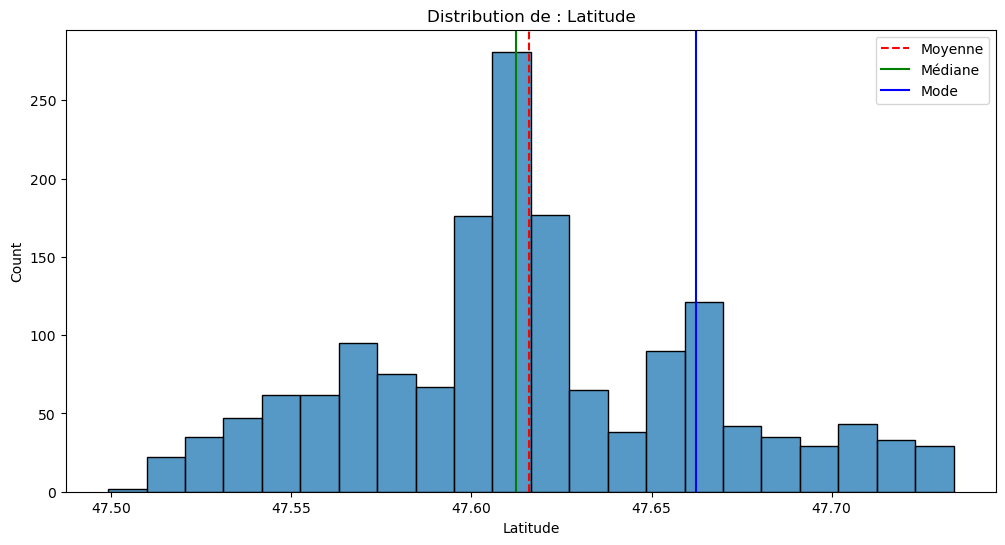

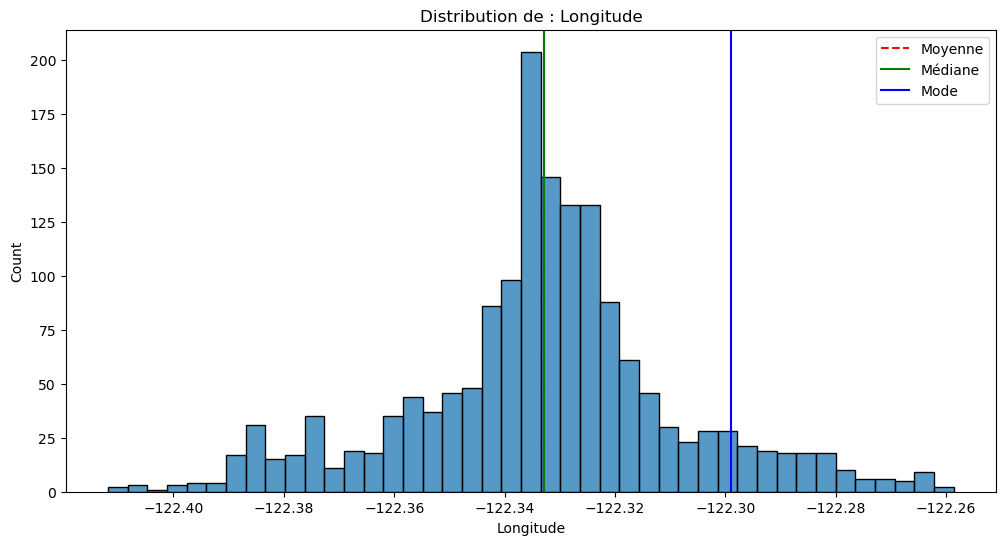

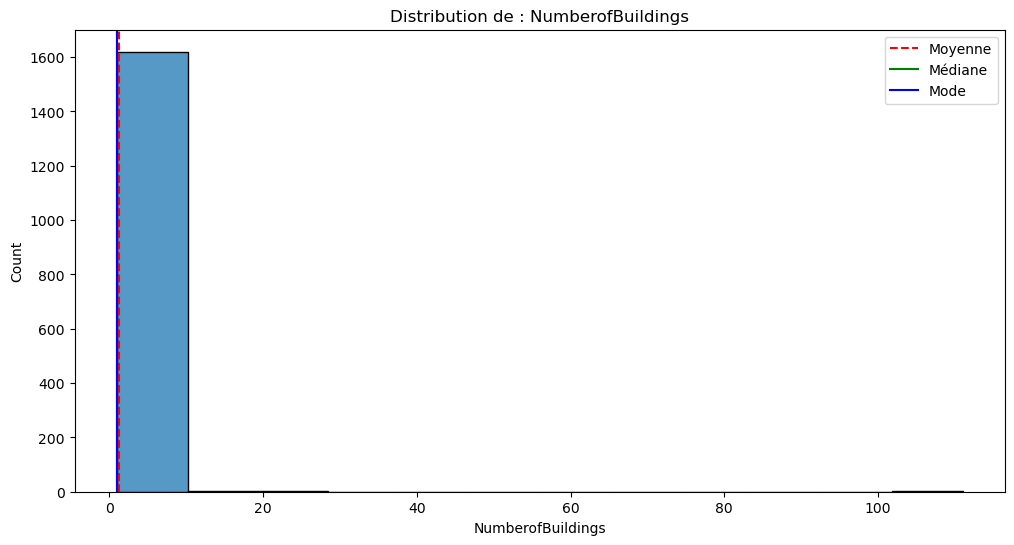

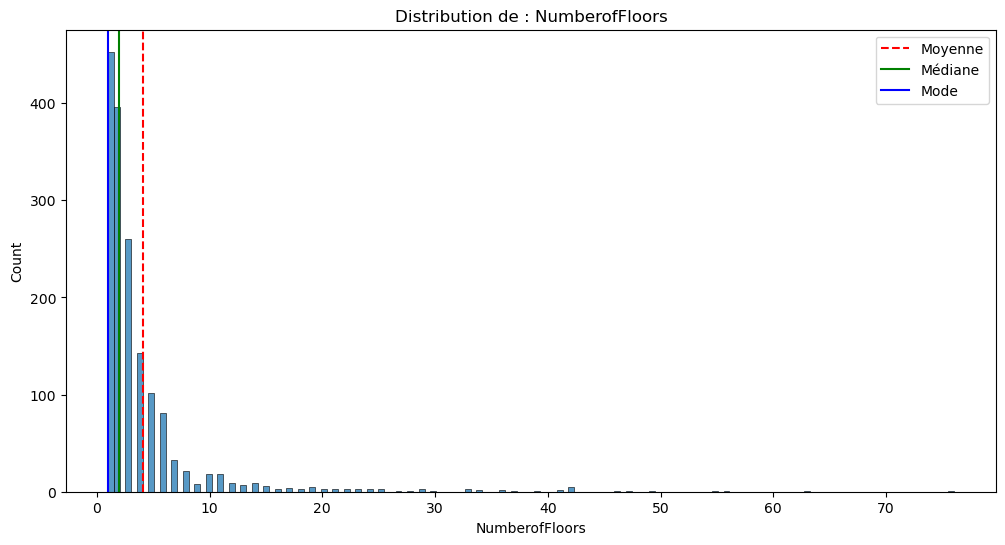

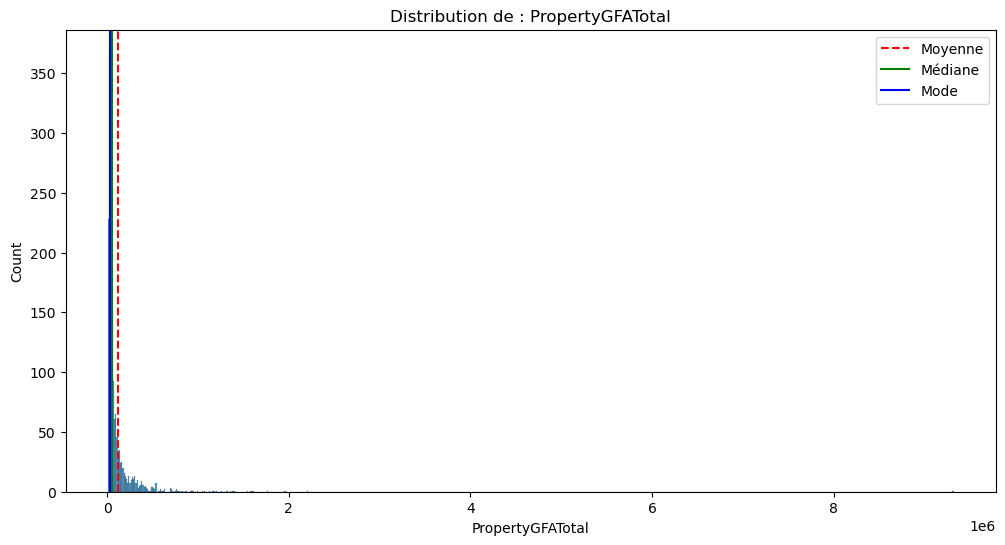

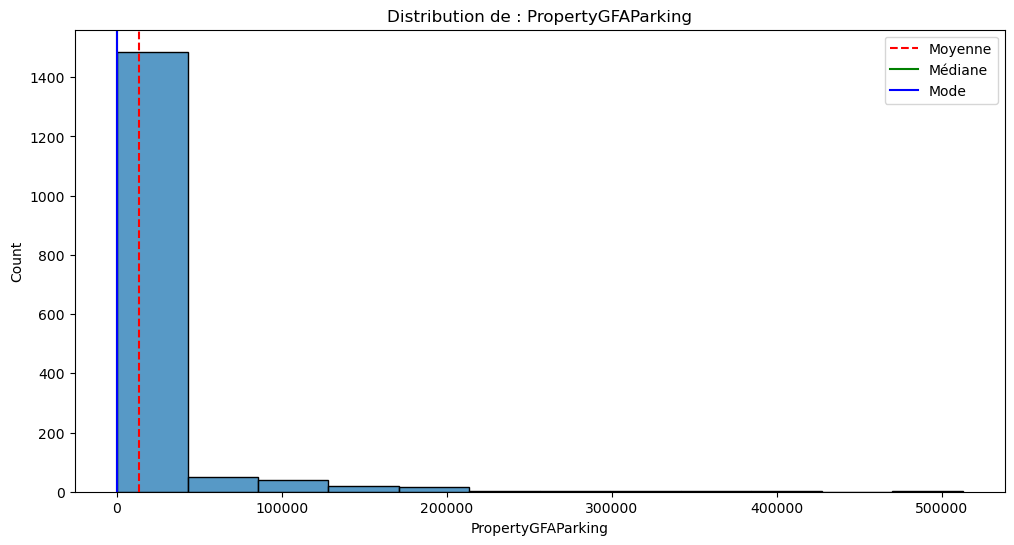

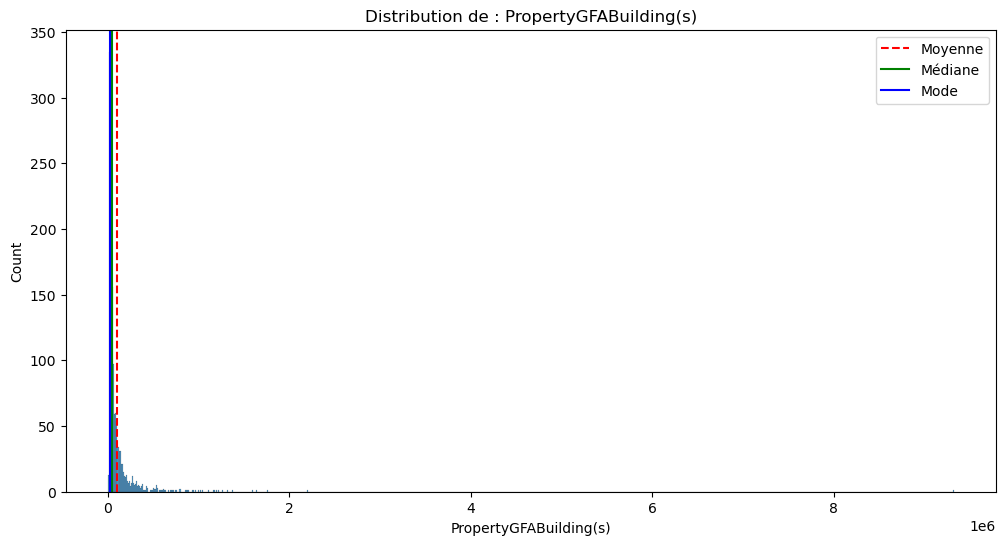

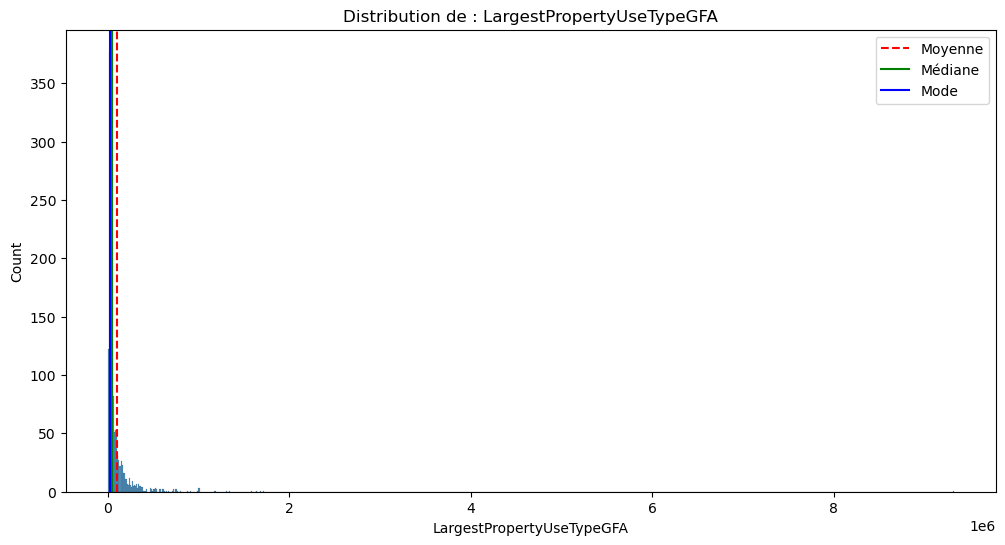

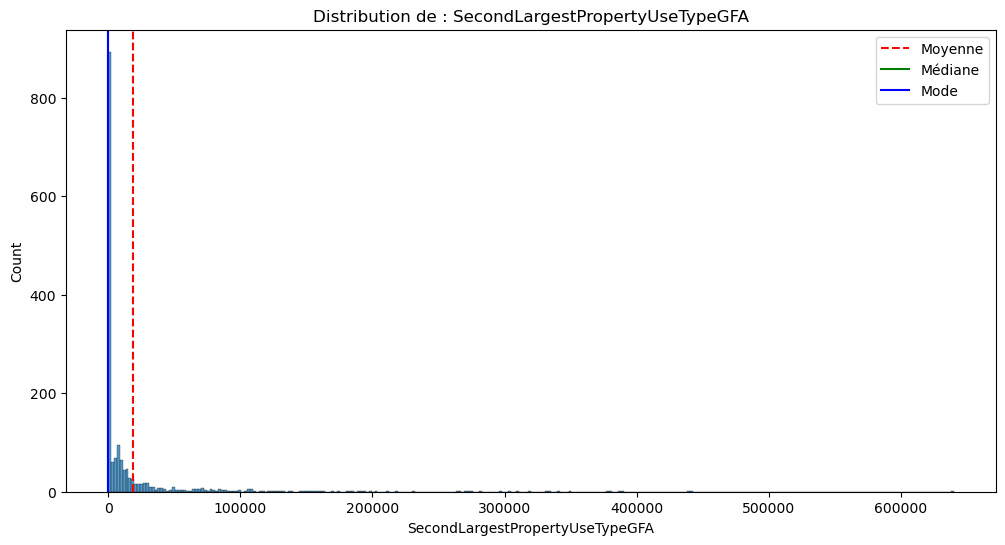

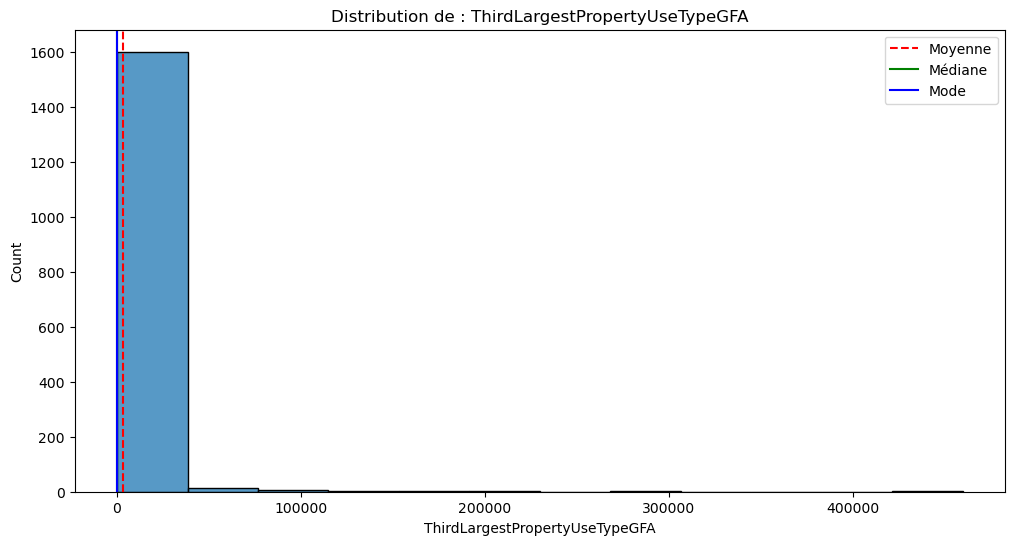

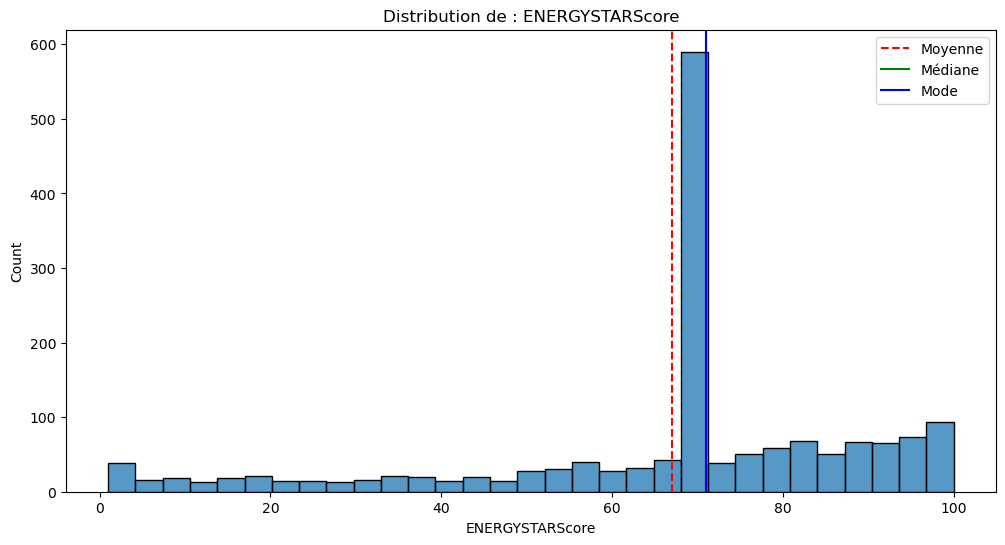

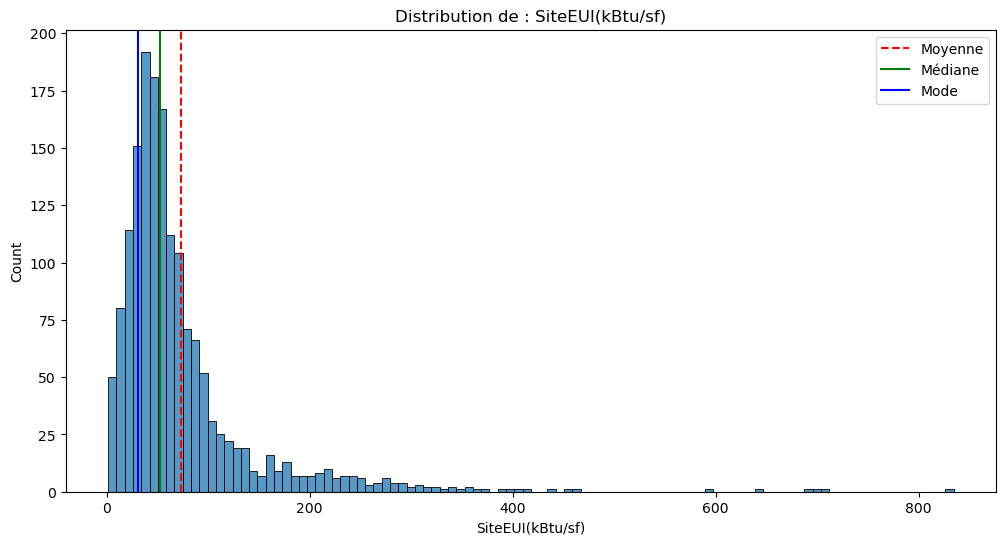

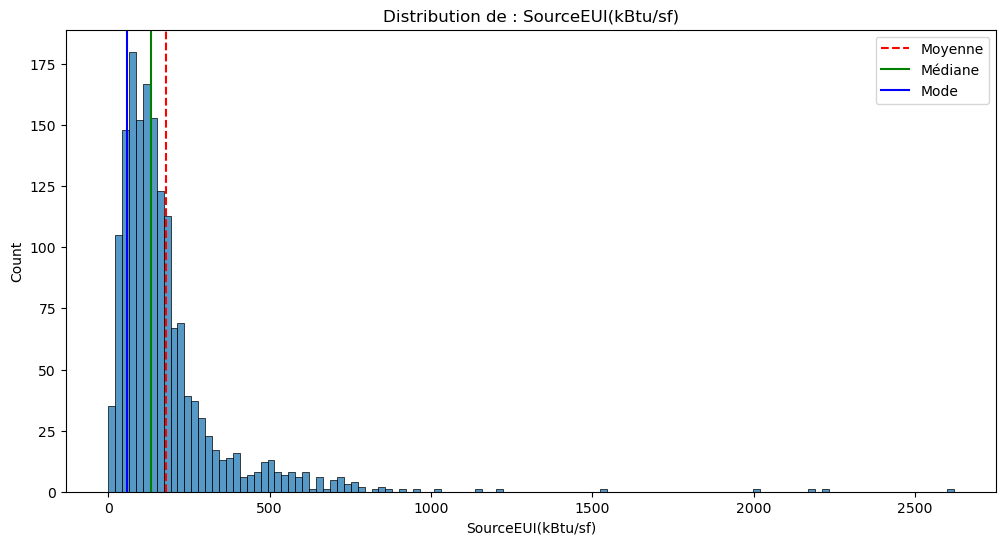

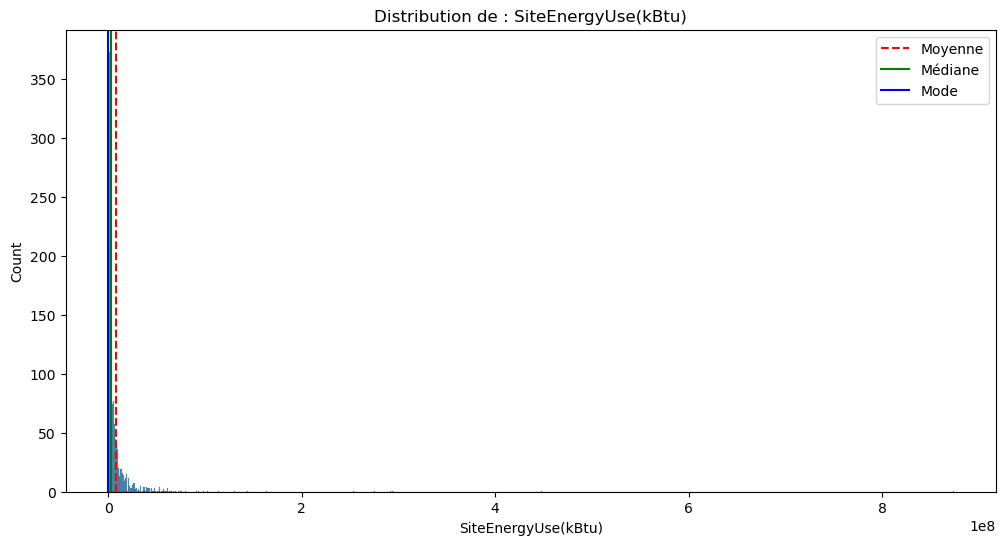

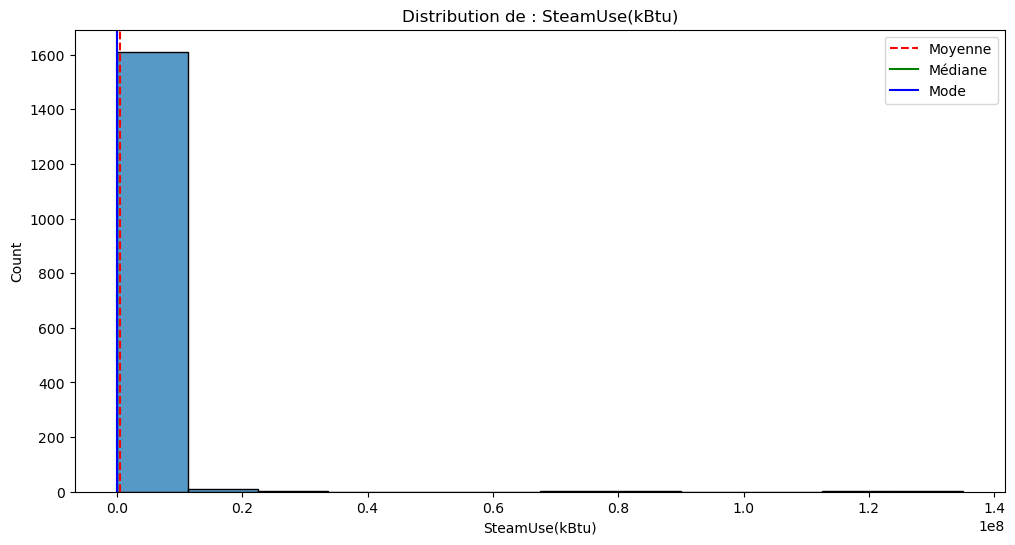

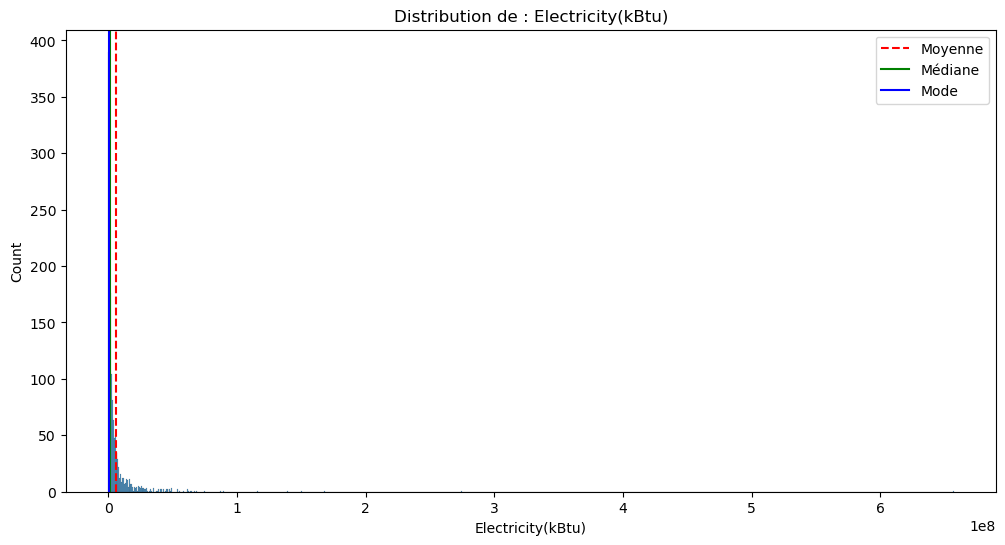

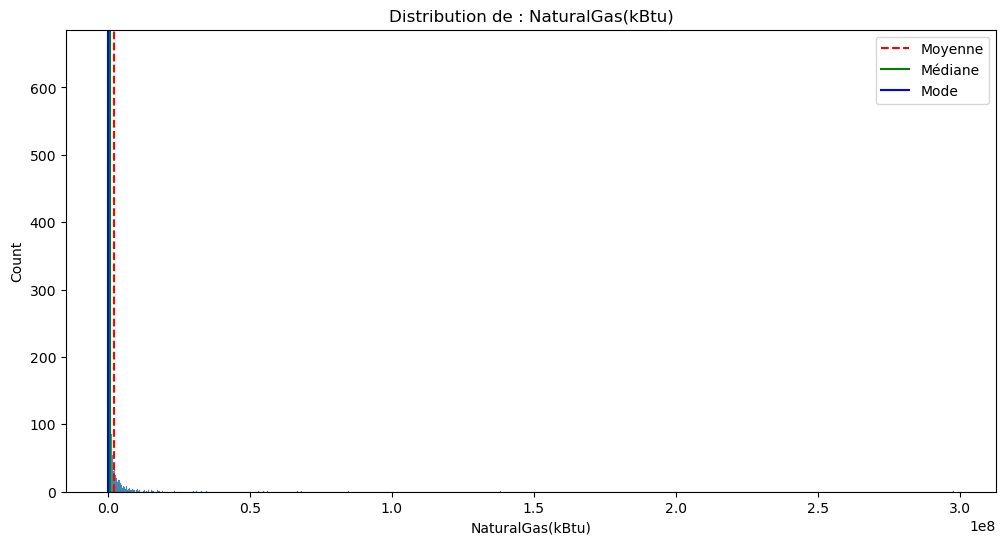

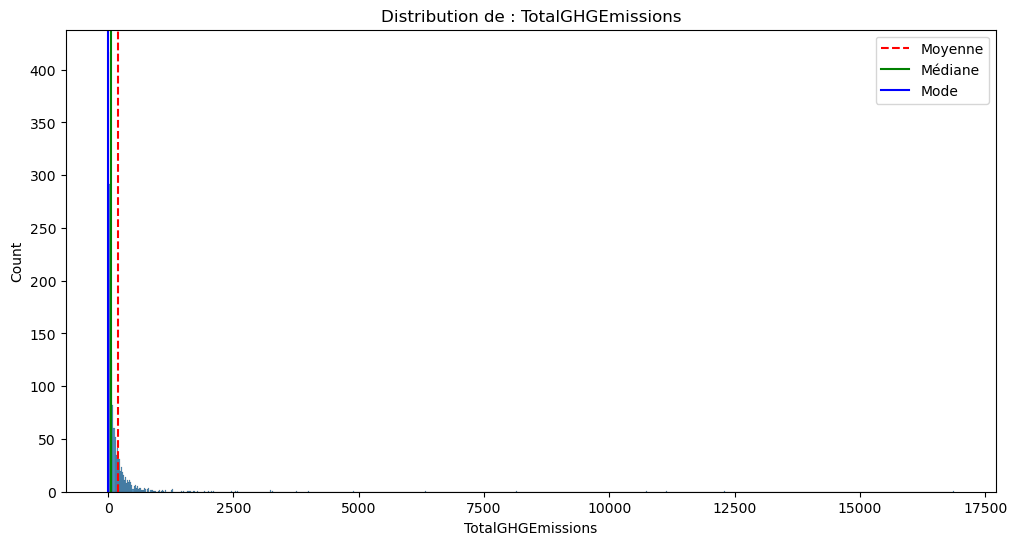

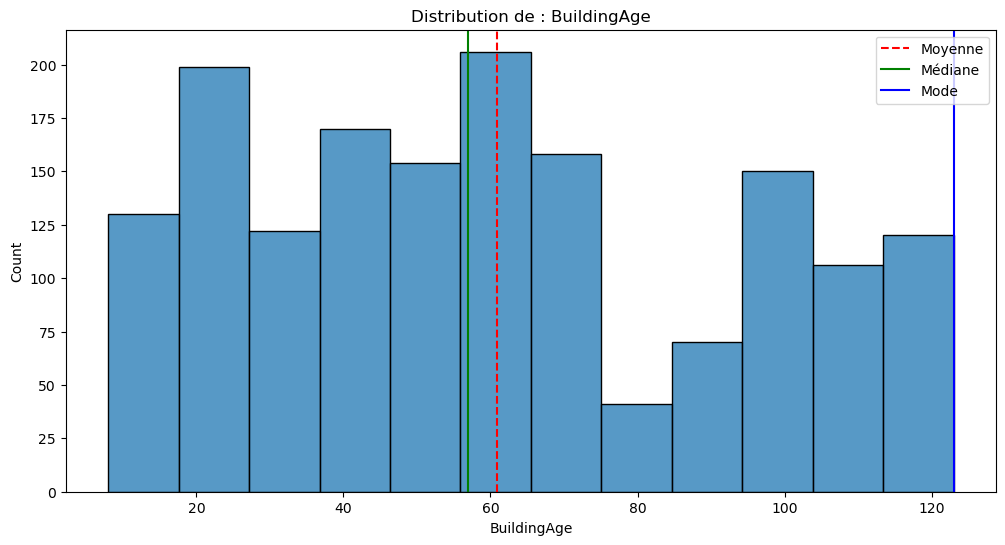

In [60]:
for col in df.select_dtypes("number"):
    plt.figure(figsize = (12,6))
    sns.histplot(df[col])
    plt.axvline(df[col].mean(), color='r', linestyle='--', label="Moyenne")
    plt.axvline(df[col].median(), color='g', linestyle='-', label="Médiane")
    plt.axvline(df[col].mode().values[0], color='b', linestyle='-', label="Mode")
    chaine = 'Distribution de : ' + col
    plt.title(chaine)
    plt.legend()
    plt.show()

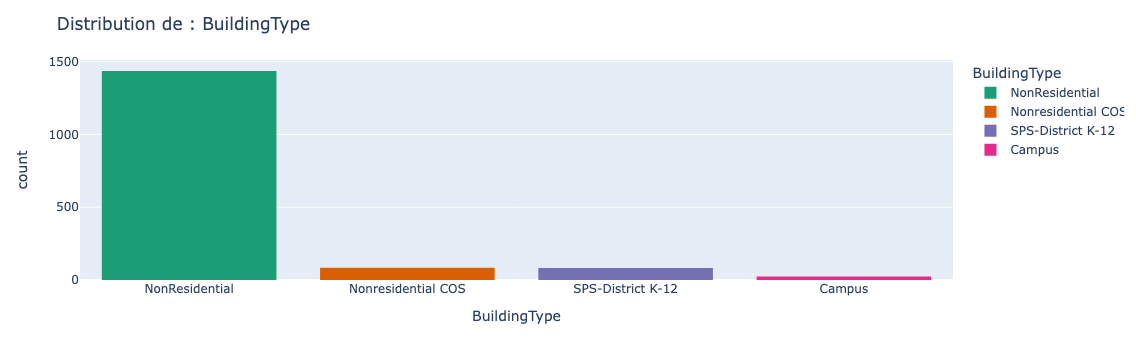

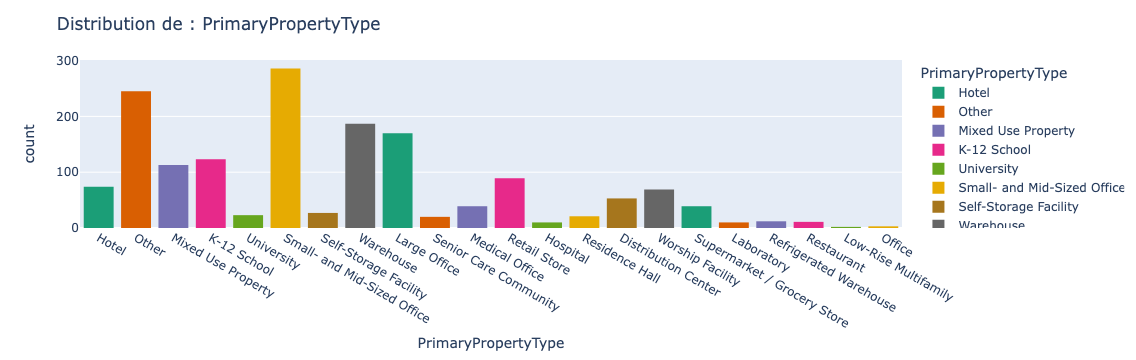

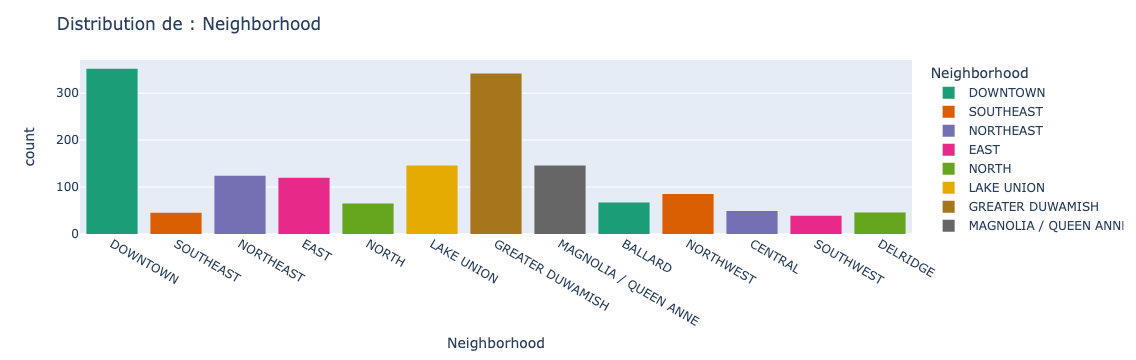

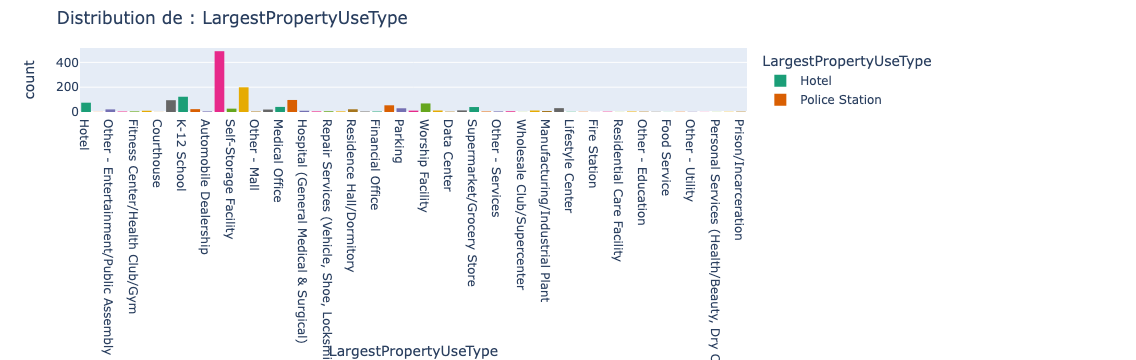

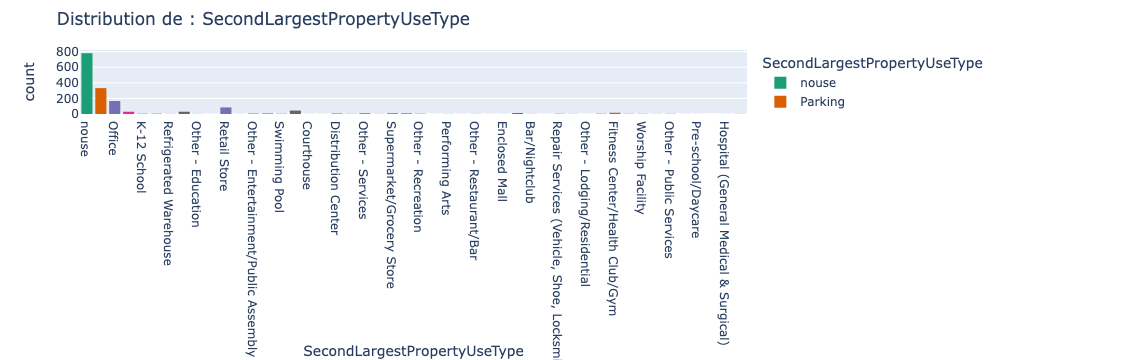

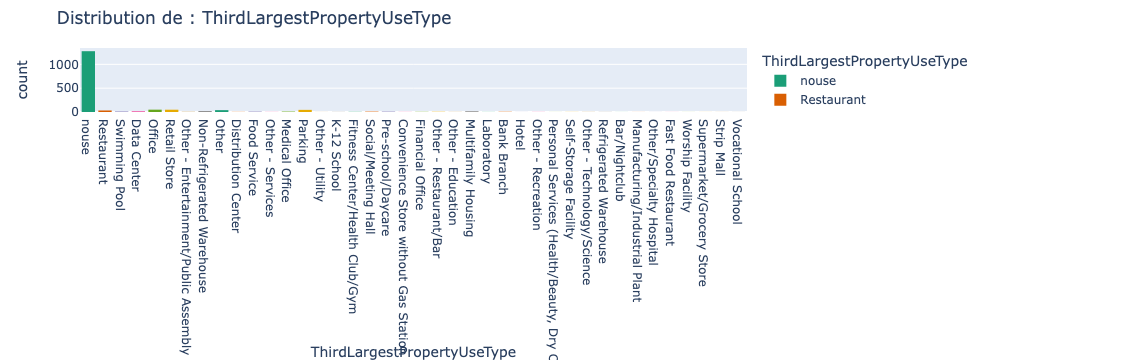

In [61]:
categorical = df.select_dtypes("object").columns.tolist()
categorical.remove('ListOfAllPropertyUseTypes')
categorical.remove('PropertyName')
for cols in categorical: 
    fig = px.histogram(df, x=cols, color = cols, color_discrete_sequence=px.colors.qualitative.Dark2)
    chaine = 'Distribution de : ' + cols
    fig.update_layout(title= chaine)
    fig.show()

### Corrélations

Pour garantir l'intégrité de nos modèles prédictifs, nous devons nous assurer qu'aucune paire de variables ne présente une corrélation de Pearson supérieure à 0.75.

<AxesSubplot:>

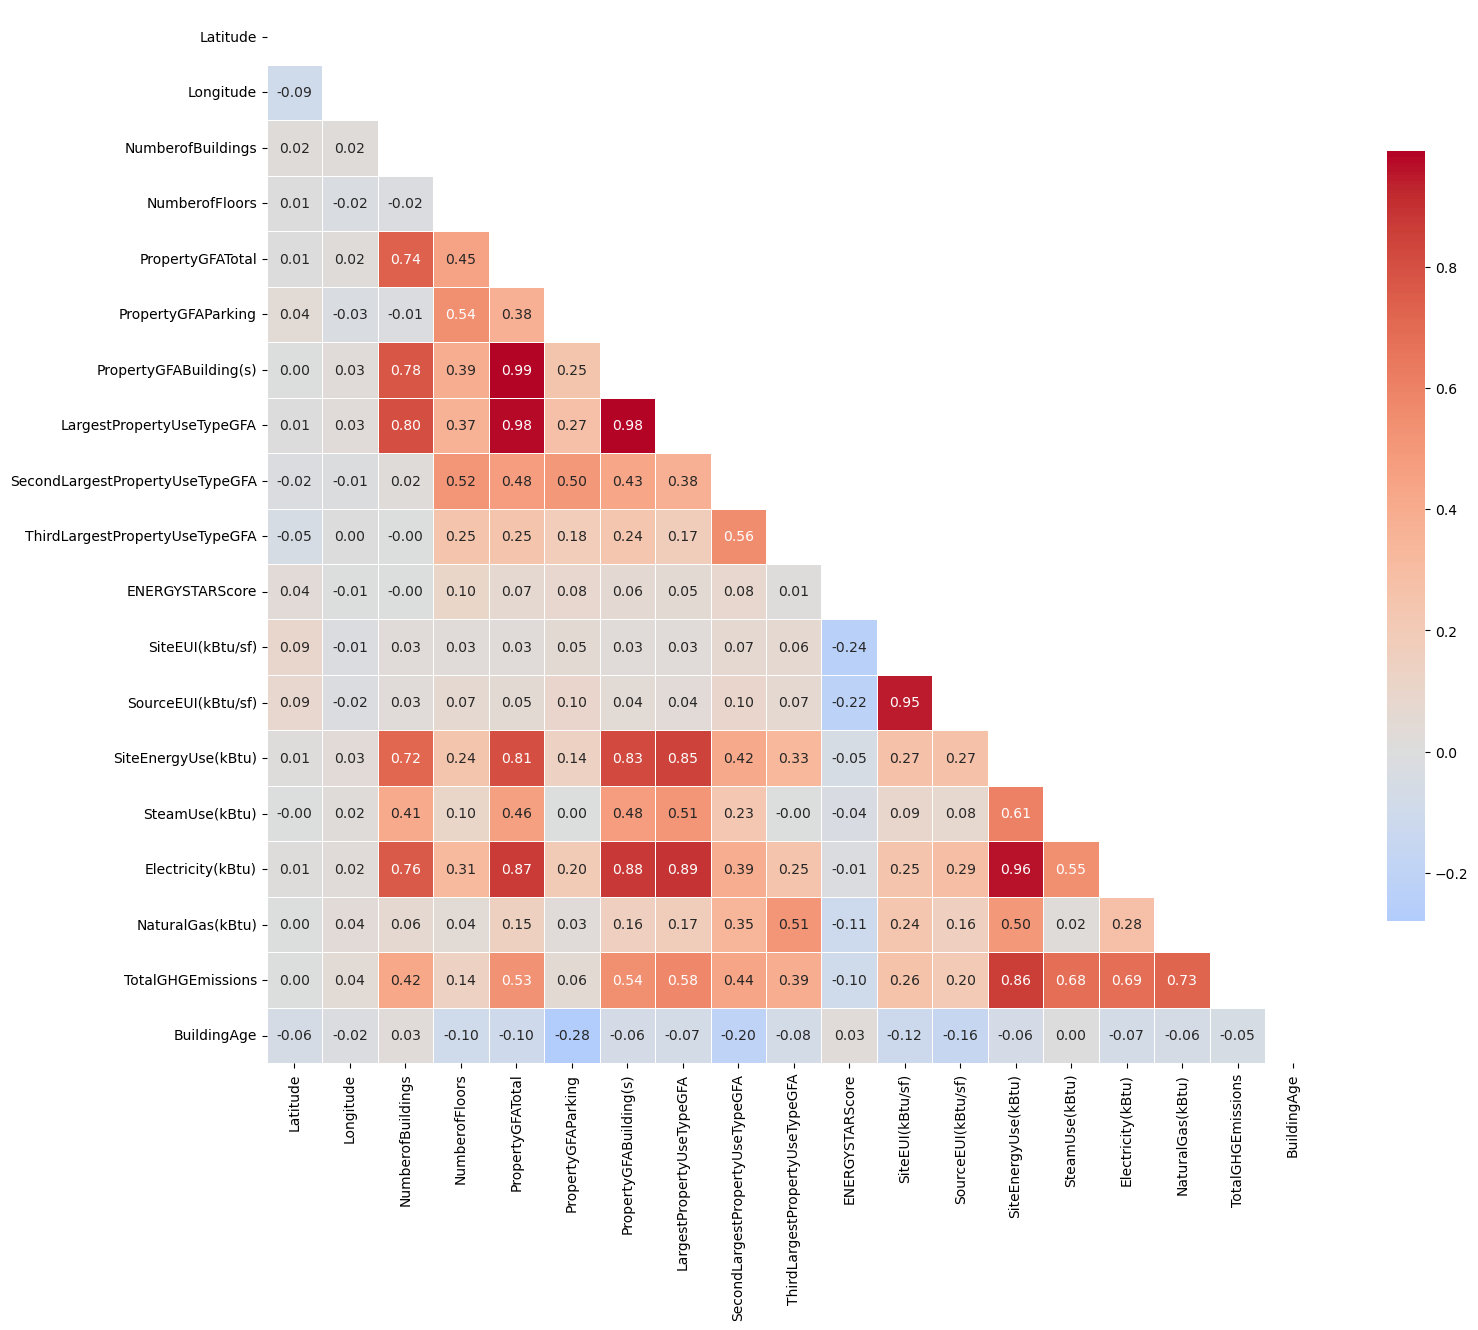

In [62]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Création d'un masque pour ne montrer que la moitié inférieure de la matrice
masking = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialisation de la figure matplotlib
fig, ax = plt.subplots(figsize=(17, 20))

# Dessin de la carte de chaleur avec le masque et le bon ratio d'aspect
sns.heatmap(correlation_matrix, mask=masking, cmap="coolwarm", annot=True, fmt=".2f",
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nous avons de fortes corrélation entre les variables de Property type

## Feature engineering

Afin de diminuer la colinéarité entre les variables de surfaces calculons les pourcentages de chaque variable en fonction de la surface totale.

In [64]:
df = df.copy()

df["ParkingRatio"] = round(df.PropertyGFAParking / df.PropertyGFATotal, 4)

df["BuildingRatio"] = round(df["PropertyGFABuilding(s)"] / df["PropertyGFATotal"], 4)

df["FloorsRatio"] = round(df.PropertyGFATotal / df.NumberofFloors, 4)

df["BuildingsRatio"] = round(df.PropertyGFATotal / df.NumberofBuildings, 4)

df["LargestUseTypeRatio"] = round(df.LargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)

df["SecondLargestUseTypeRatio"] = round(df.SecondLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)

df["ThirdLargestUseTypeRatio"] = round(df.ThirdLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)

In [65]:
df["NumberOfAllUseTypes"]= df.ListOfAllPropertyUseTypes.apply(lambda row: len(row))

In [66]:
cols_to_drop = ["PropertyGFAParking", "PropertyGFABuilding(s)",
                "NumberofFloors", "NumberofBuildings",
                "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
               "ThirdLargestPropertyUseTypeGFA", "ListOfAllPropertyUseTypes"]
df.drop(columns = cols_to_drop,inplace = True)

In [67]:
df.dtypes

BuildingType                     object
PrimaryPropertyType              object
PropertyName                     object
Neighborhood                     object
Latitude                        float64
Longitude                       float64
PropertyGFATotal                  int64
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ThirdLargestPropertyUseType      object
ENERGYSTARScore                 float64
SiteEUI(kBtu/sf)                float64
SourceEUI(kBtu/sf)              float64
SiteEnergyUse(kBtu)             float64
SteamUse(kBtu)                  float64
Electricity(kBtu)               float64
NaturalGas(kBtu)                float64
TotalGHGEmissions               float64
BuildingAge                       int64
ParkingRatio                    float64
BuildingRatio                   float64
FloorsRatio                     float64
BuildingsRatio                  float64
LargestUseTypeRatio             float64
SecondLargestUseTypeRatio       float64


In [68]:
df

BuildingType PrimaryPropertyType  \
0         NonResidential               Hotel   
1         NonResidential               Hotel   
2         NonResidential               Hotel   
3         NonResidential               Hotel   
4         NonResidential               Hotel   
...                  ...                 ...   
1626  Nonresidential COS              Office   
1627  Nonresidential COS               Other   
1628  Nonresidential COS               Other   
1629  Nonresidential COS  Mixed Use Property   
1630  Nonresidential COS  Mixed Use Property   

                             PropertyName           Neighborhood  Latitude  \
0                    Mayflower park hotel               DOWNTOWN  47.61220   
1                         Paramount Hotel               DOWNTOWN  47.61317   
2                 5673-The Westin Seattle               DOWNTOWN  47.61393   
3                               HOTEL MAX               DOWNTOWN  47.61412   
4             WARWICK SEATTLE HOTEL (ID8)               DOWNTOWN  47.61375   
...                                   ...                    ...       ...   
1626                Horticulture building       GREATER DUWAMISH  47.56722   
1627  International district/Chinatown CC               DOWNTOWN  47.59625   
1628                      Queen Anne Pool  MAGNOLIA / QUEEN ANNE  47.63644   
1629          South Park Community Center       GREATER DUWAMISH  47.52832   
1630          Van Asselt Community Center       GREATER DUWAMISH  47.53939   

      Longitude  PropertyGFATotal LargestPropertyUseType  \
0    -122.33799             88434                  Hotel   
1    -122.33393            103566                  Hotel   
2    -122.33810            956110                  Hotel   
3    -122.33664             61320                  Hotel   
4    -122.34047            175580                  Hotel   
...         ...               ...                    ...   
1626 -122.31154             12294                 Office   
1627 -122.32283             16000     Other - Recreation   
1628 -122.35784             13157     Other - Recreation   
1629 -122.32431             14101     Other - Recreation   
1630 -122.29536             18258     Other - Recreation   

        SecondLargestPropertyUseType ThirdLargestPropertyUseType  ...  \
0                              nouse                       nouse  ...   
1                            Parking                  Restaurant  ...   
2                              nouse                       nouse  ...   
3                              nouse                       nouse  ...   
4                            Parking               Swimming Pool  ...   
...                              ...                         ...  ...   
1626                           nouse                       nouse  ...   
1627                           nouse                       nouse  ...   
1628  Fitness Center/Health Club/Gym               Swimming Pool  ...   
1629  Fitness Center/Health Club/Gym          Pre-school/Daycare  ...   
1630  Fitness Center/Health Club/Gym          Pre-school/Daycare  ...   

      TotalGHGEmissions  BuildingAge  ParkingRatio  BuildingRatio  \
0                249.98           96        0.0000         1.0000   
1                295.86           27        0.1455         0.8545   
2               2089.28           54        0.2057         0.7943   
3                286.43           97        0.0000         1.0000   
4                505.01           43        0.3531         0.6469   
...                 ...          ...           ...            ...   
1626              20.94           33        0.0000         1.0000   
1627              32.17           19        0.0000         1.0000   
1628             223.54           49        0.0000         1.0000   
1629              22.11           34        0.0000         1.0000   
1630              41.27           85        0.0000         1.0000   

      FloorsRatio  BuildingsRatio  LargestUseTypeRatio  \
0       7369.

<AxesSubplot:>

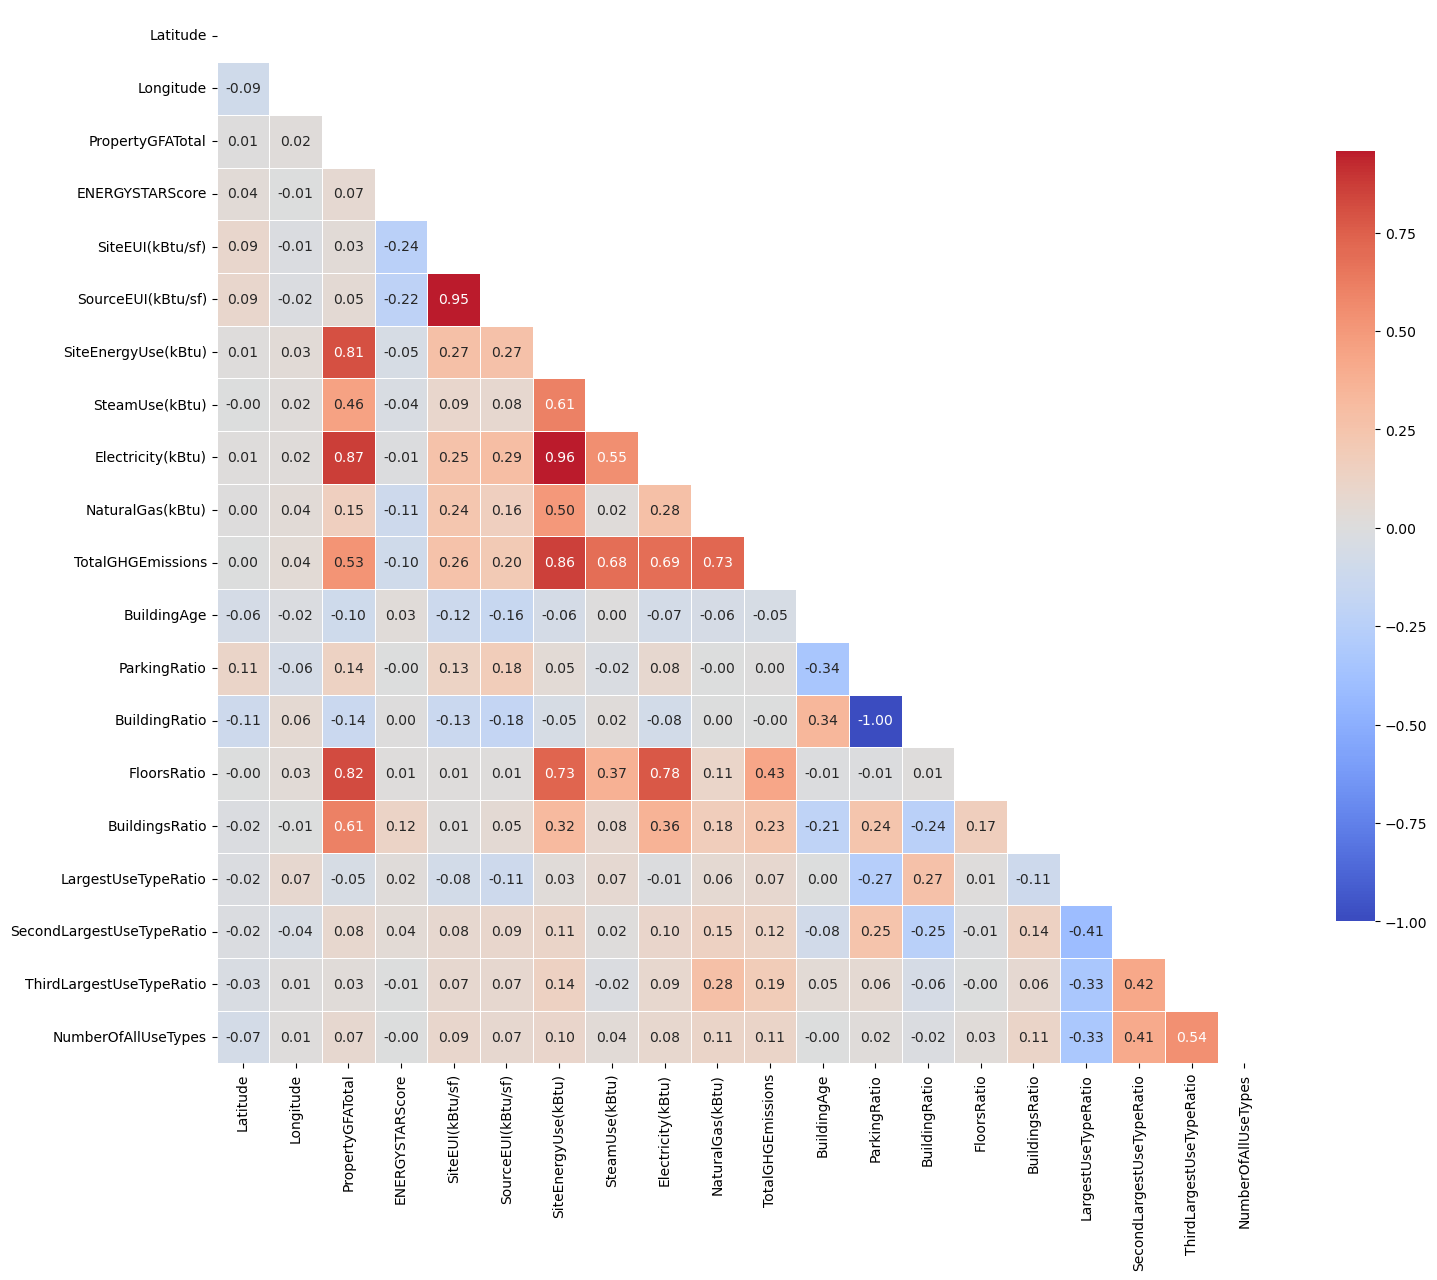

In [72]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Création d'un masque pour ne montrer que la moitié inférieure de la matrice
masking = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialisation de la figure matplotlib
fig, ax = plt.subplots(figsize=(17, 20))

# Dessin de la carte de chaleur avec le masque et le bon ratio d'aspect
sns.heatmap(correlation_matrix, mask=masking, cmap="coolwarm", annot=True, fmt=".2f",
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

SiteEUI(kBtu/sf) : Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area.

C'est une variable surfacique. On peut donc la supprimer car on dispose de SiteEnergyUse

SourceEUI(kBtu/sf) : Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area.

C'est une variable surfacique. On peut la supprimer.

In [73]:
df.drop(["SourceEUI(kBtu/sf)","SiteEUI(kBtu/sf)"], axis = 1, inplace= True)

<AxesSubplot:>

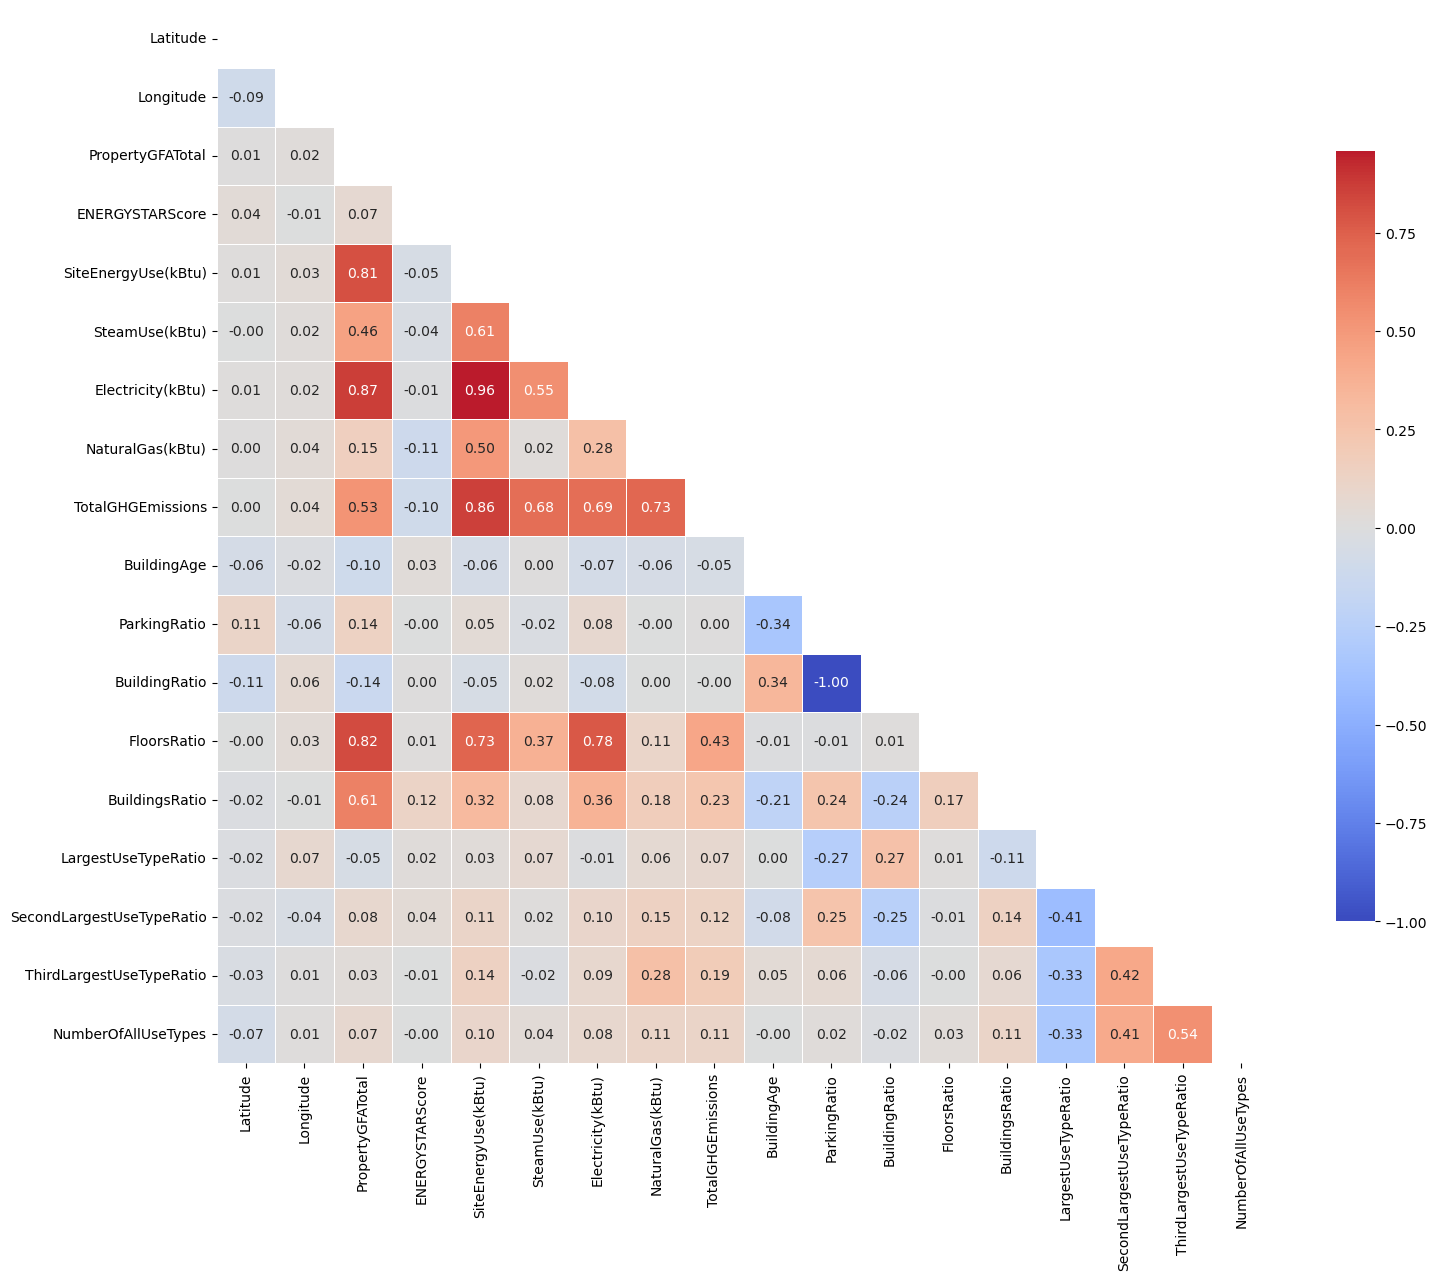

In [75]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Création d'un masque pour ne montrer que la moitié inférieure de la matrice
masking = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialisation de la figure matplotlib
fig, ax = plt.subplots(figsize=(17, 20))

# Dessin de la carte de chaleur avec le masque et le bon ratio d'aspect
sns.heatmap(correlation_matrix, mask=masking, cmap="coolwarm", annot=True, fmt=".2f",
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Si un type d'énergie est utilisé dans le bâtiment (c'est-à-dire, si sa consommation est supérieure à zéro), nous marquons cette utilisation par un 1. Sinon (c'est-à-dire, si sa consommation est égale à zéro), nous marquons l'absence d'utilisation par un 0

In [74]:
df[["Electricity(kBtu)","SteamUse(kBtu)", "NaturalGas(kBtu)"]]

Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
0          3.946027e+06      2003882.00      1.276453e+06
1          3.242851e+06            0.00      5.145082e+06
2          4.952666e+07     21566554.00      1.493800e+06
3          2.768924e+06      2214446.25      1.811213e+06
4          5.368607e+06            0.00      8.803998e+06
...                 ...             ...               ...
1626       5.242709e+05            0.00      3.254750e+05
1627       3.965461e+05            0.00      5.537300e+05
1628       1.792159e+06            0.00      3.973739e+06
1629       3.488702e+05            0.00      3.706010e+05
1630       4.325542e+05            0.00      7.203420e+05

[1626 rows x 3 columns]

In [76]:
def convert_columns_to_binary(df, column_name):
    df[column_name] = np.where(df[column_name] > 0, 1, 0)
    return df

columns_to_convert = ["Electricity(kBtu)","SteamUse(kBtu)", "NaturalGas(kBtu)"]

for column in columns_to_convert:
    df = convert_columns_to_binary(df, column)

In [77]:
df[["Electricity(kBtu)","SteamUse(kBtu)", "NaturalGas(kBtu)"]]

Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
0                     1               1                 1
1                     1               0                 1
2                     1               1                 1
3                     1               1                 1
4                     1               0                 1
...                 ...             ...               ...
1626                  1               0                 1
1627                  1               0                 1
1628                  1               0                 1
1629                  1               0                 1
1630                  1               0                 1

[1626 rows x 3 columns]

<AxesSubplot:>

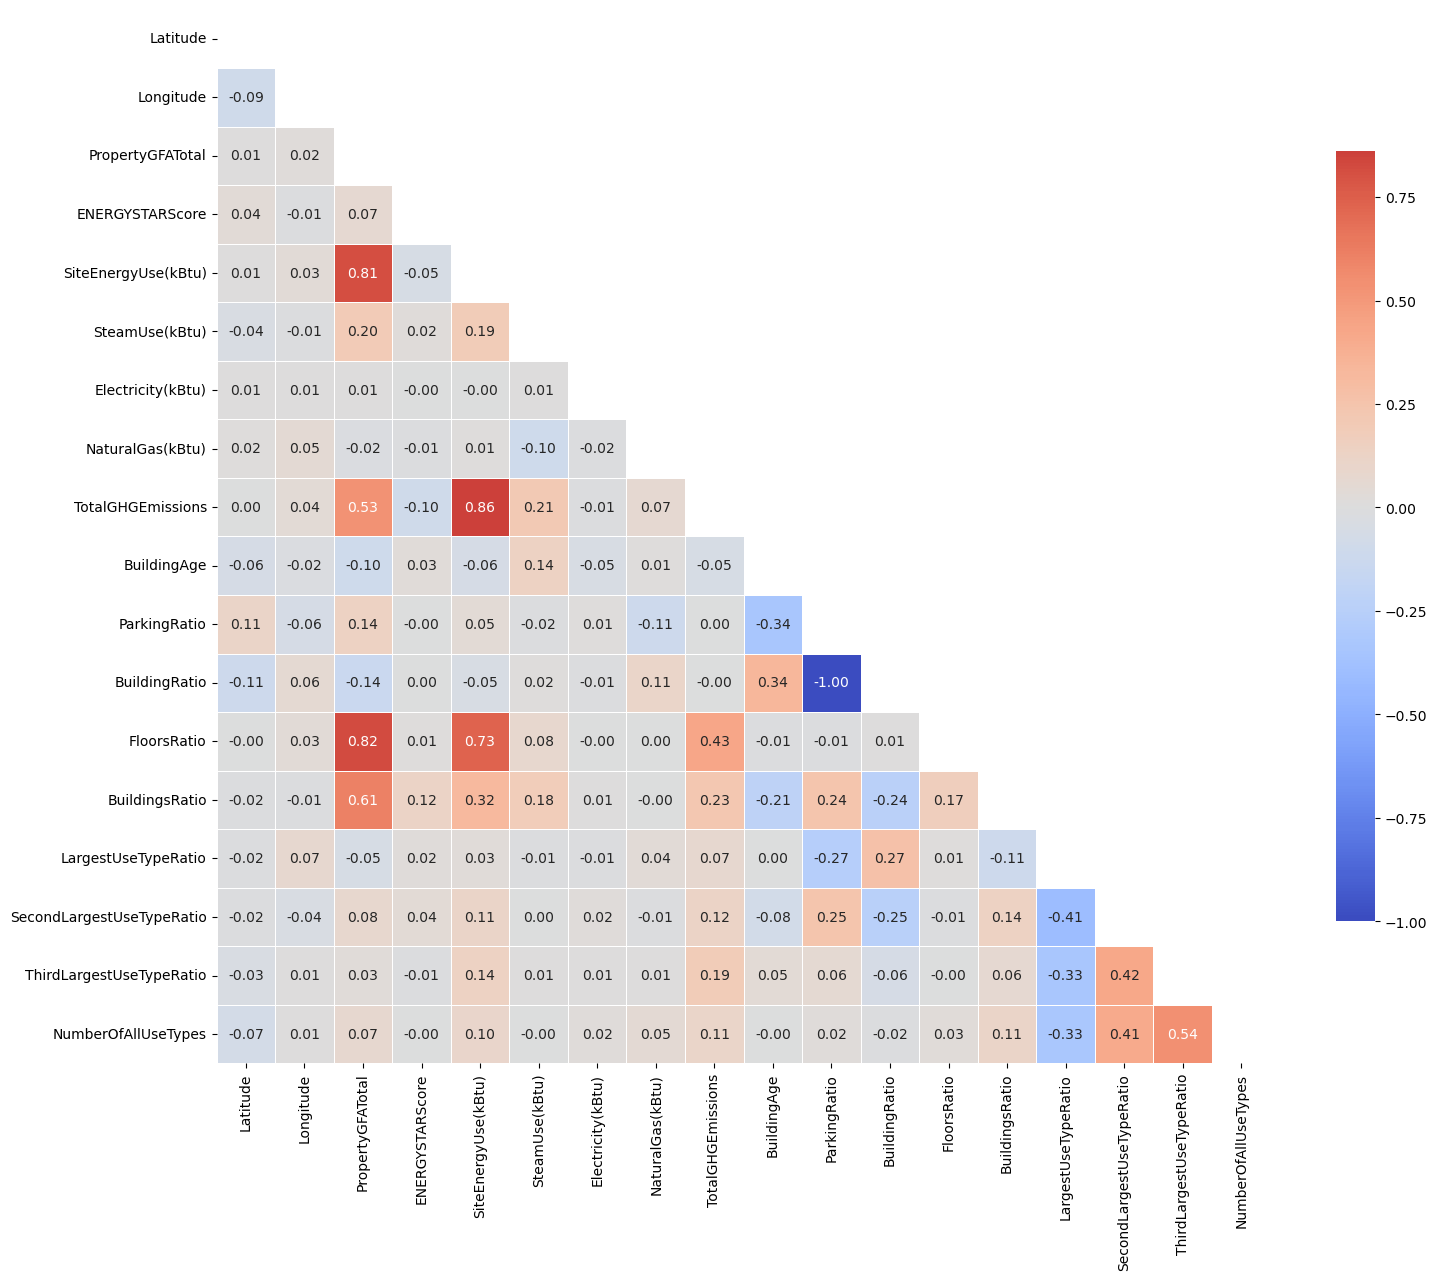

In [78]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Création d'un masque pour ne montrer que la moitié inférieure de la matrice
masking = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialisation de la figure matplotlib
fig, ax = plt.subplots(figsize=(17, 20))

# Dessin de la carte de chaleur avec le masque et le bon ratio d'aspect
sns.heatmap(correlation_matrix, mask=masking, cmap="coolwarm", annot=True, fmt=".2f",
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Il ne reste qu'une variable qui présente plusieurs corrélations supérieures à 0.75 : PropertyGFATotal.

In [80]:
df.drop("PropertyGFATotal", axis = 1, inplace = True)

<AxesSubplot:>

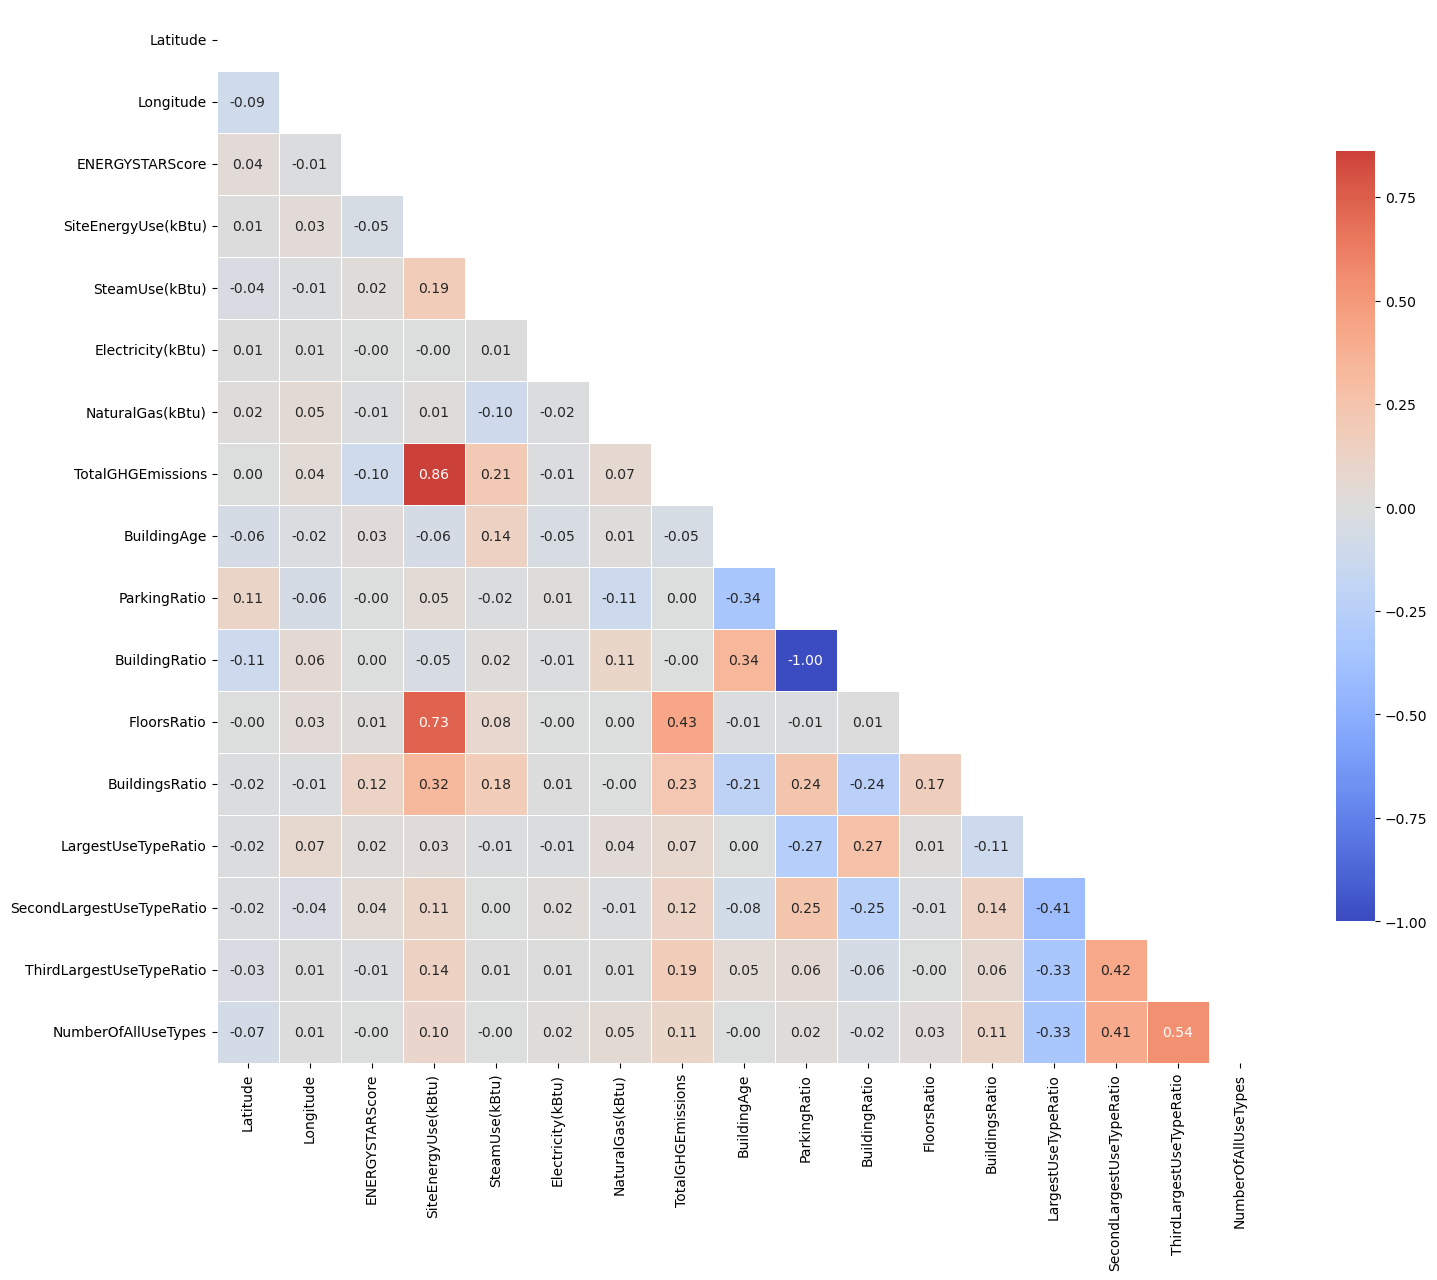

In [81]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Création d'un masque pour ne montrer que la moitié inférieure de la matrice
masking = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialisation de la figure matplotlib
fig, ax = plt.subplots(figsize=(17, 20))

# Dessin de la carte de chaleur avec le masque et le bon ratio d'aspect
sns.heatmap(correlation_matrix, mask=masking, cmap="coolwarm", annot=True, fmt=".2f",
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Calculons la distance de Haversine par rapport au centre de Seattle.

- Latitude et longitude de Seattle (WA)

- Latitude de Seattle (WA): 47.6062095

- Longitude de Seattle (WA): -122.3320708

In [83]:
from haversine import haversine

latitude_Seattle = 47.6062
longitude_Seattle = -122.3320

central_position = (latitude_Seattle, longitude_Seattle)


df['coordinate_pair'] = list(zip(df['Latitude'], df['Longitude']))
df['distance_from_center'] = df['coordinate_pair'].apply(lambda coords: haversine(coords, central_position))

In [84]:
df.drop(columns = ["Latitude","Longitude","coordinate_pair"], inplace = True)

In [85]:
df

BuildingType PrimaryPropertyType  \
0         NonResidential               Hotel   
1         NonResidential               Hotel   
2         NonResidential               Hotel   
3         NonResidential               Hotel   
4         NonResidential               Hotel   
...                  ...                 ...   
1626  Nonresidential COS              Office   
1627  Nonresidential COS               Other   
1628  Nonresidential COS               Other   
1629  Nonresidential COS  Mixed Use Property   
1630  Nonresidential COS  Mixed Use Property   

                             PropertyName           Neighborhood  \
0                    Mayflower park hotel               DOWNTOWN   
1                         Paramount Hotel               DOWNTOWN   
2                 5673-The Westin Seattle               DOWNTOWN   
3                               HOTEL MAX               DOWNTOWN   
4             WARWICK SEATTLE HOTEL (ID8)               DOWNTOWN   
...                                   ...                    ...   
1626                Horticulture building       GREATER DUWAMISH   
1627  International district/Chinatown CC               DOWNTOWN   
1628                      Queen Anne Pool  MAGNOLIA / QUEEN ANNE   
1629          South Park Community Center       GREATER DUWAMISH   
1630          Van Asselt Community Center       GREATER DUWAMISH   

     LargestPropertyUseType    SecondLargestPropertyUseType  \
0                     Hotel                           nouse   
1                     Hotel                         Parking   
2                     Hotel                           nouse   
3                     Hotel                           nouse   
4                     Hotel                         Parking   
...                     ...                             ...   
1626                 Office                           nouse   
1627     Other - Recreation                           nouse   
1628     Other - Recreation  Fitness Center/Health Club/Gym   
1629     Other - Recreation  Fitness Center/Health Club/Gym   
1630     Other - Recreation  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
0                          nouse             60.0         7.226362e+06   
1                     Restaurant             61.0         8.387933e+06   
2                          nouse             43.0         7.258702e+07   
3                          nouse             56.0         6.794584e+06   
4                  Swimming Pool             75.0         1.417261e+07   
...                          ...              ...                  ...   
1626                       nouse             46.0         8.497457e+05   
1627                       nouse             69.0         9.502762e+05   
1628               Swimming Pool             69.0         5.765898e+06   
1629          Pre-school/Daycare             69.0         7.194712e+05   
1630          Pre-school/Daycare             69.0         1.152896e+06   

      SteamUse(kBtu)  ...  BuildingAge  ParkingRatio  BuildingRatio  \
0                  1  ...           96        0.0000         1.0000   
1                  0  ...           27        0.1455         0.8545   
2                  1  ...           54        0.2057         0.7943   
3                  1  ...           97        0.0000         1.0000   
4                  0  ...           43        0.3531         0.6469   
...              ...  ...          ...           ...            ...   
1626               0  ...           33        0.0000         1.0000   
1627               0  ...           19        0.0000         1.0000   
1628               0  ...           49        0.0000         1.0000   
1629               0  ...           34        0.0000         1.0000   
1630               0  ...           85        0.0000         1.0000   

      FloorsRatio  BuildingsRatio  LargestUseTypeRatio  \
0       7369.5000         88434.0               1.0000   
1  

## Analyse des Target

In [86]:
df.columns 

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'ParkingRatio', 'BuildingRatio',
       'FloorsRatio', 'BuildingsRatio', 'LargestUseTypeRatio',
       'SecondLargestUseTypeRatio', 'ThirdLargestUseTypeRatio',
       'NumberOfAllUseTypes', 'distance_from_center'],
      dtype='object')

In [90]:
from scipy.stats import shapiro


# Extraire les colonnes 'TotalGHGEmissions' et 'SiteEnergyUse(kBtu)'
total_ghg_emissions = df['TotalGHGEmissions']
site_energy_use = df['SiteEnergyUse(kBtu)']

# Effectuer le test de Shapiro-Wilk
ghg_stat, ghg_p = shapiro(total_ghg_emissions)
energy_stat, energy_p = shapiro(site_energy_use)

# Afficher les résultats
print("Test de Shapiro-Wilk pour 'TotalGHGEmissions':")
print(f"Statistique: {ghg_stat}, p-valeur: {ghg_p}")

print("\nTest de Shapiro-Wilk pour 'SiteEnergyUse(kBtu)':")
print(f"Statistique: {energy_stat}, p-valeur: {energy_p}")

# Interpréter les résultats
alpha = 0.05
if ghg_p > alpha:
    print("\n'TotalGHGEmissions' semble suivre une distribution normale.")
else:
    print("\n'TotalGHGEmissions' ne semble pas suivre une distribution normale.")

if energy_p > alpha:
    print("'SiteEnergyUse(kBtu)' semble suivre une distribution normale.")
else:
    print("'SiteEnergyUse(kBtu)' ne semble pas suivre une distribution normale.")


Test de Shapiro-Wilk pour 'TotalGHGEmissions':
Statistique: 0.17839741706848145, p-valeur: 0.0

Test de Shapiro-Wilk pour 'SiteEnergyUse(kBtu)':
Statistique: 0.19365328550338745, p-valeur: 0.0

'TotalGHGEmissions' ne semble pas suivre une distribution normale.
'SiteEnergyUse(kBtu)' ne semble pas suivre une distribution normale.


 les target ne suivent pas de loi normale

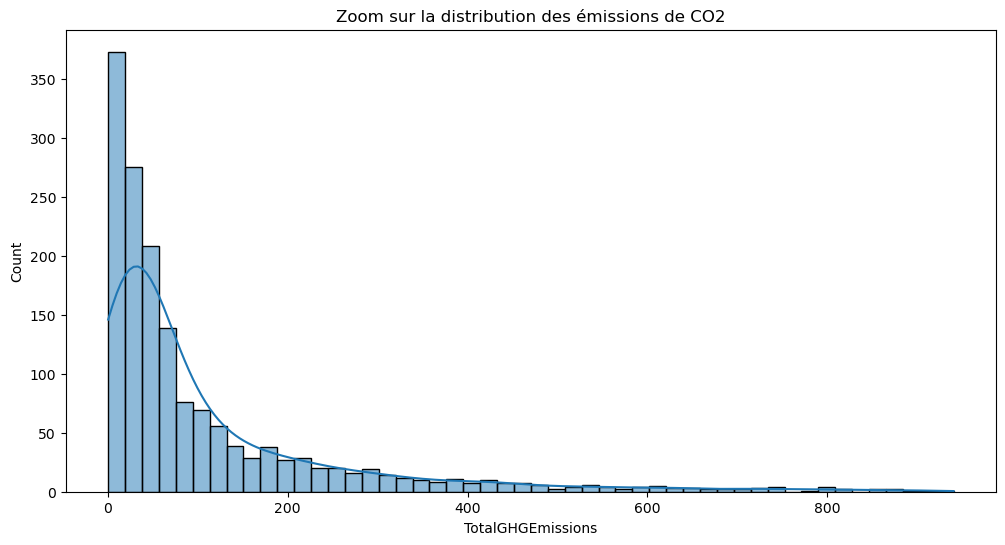

In [91]:
plt.figure(figsize = (12,6))
sns.histplot(data=df[(df['TotalGHGEmissions']< 1000)], x="TotalGHGEmissions", kde=True)
plt.title("Zoom sur la distribution des émissions de CO2")
plt.show()

On observe une forte asymétrie à droite on dois donc la transformer pour se rapprocher d'une distribution normale.

In [92]:
df["TotalGHGEmissionsLog"]= np.log10(1+df["TotalGHGEmissions"])

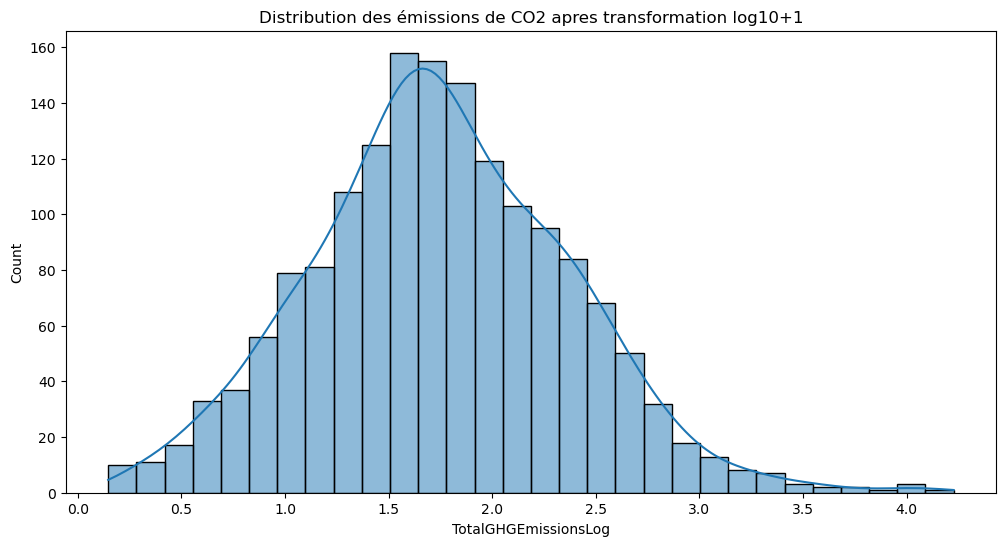

In [93]:
plt.figure(figsize = (12,6))
sns.histplot(data=df, x="TotalGHGEmissionsLog", kde=True)
plt.title("Distribution des émissions de CO2 apres transformation log10+1")
plt.show()

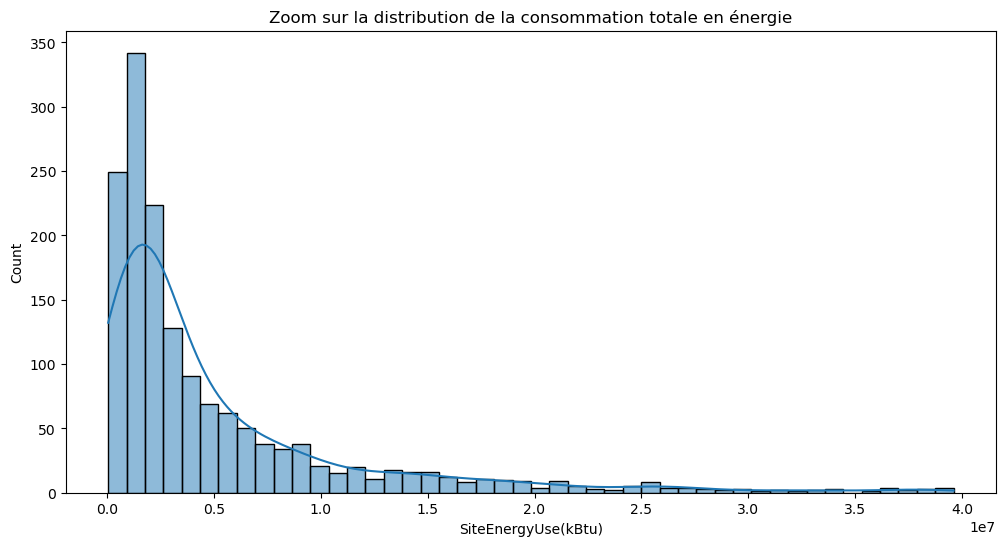

In [94]:
plt.figure(figsize = (12,6))
sns.histplot(data= df[df["SiteEnergyUse(kBtu)"]<0.4*10**8 ], x = "SiteEnergyUse(kBtu)", kde=True )
plt.title("Zoom sur la distribution de la consommation totale en énergie")
plt.show()

In [95]:
df["SiteEnergyUse(kBtu)Log"]= np.log10(1+df["SiteEnergyUse(kBtu)"])

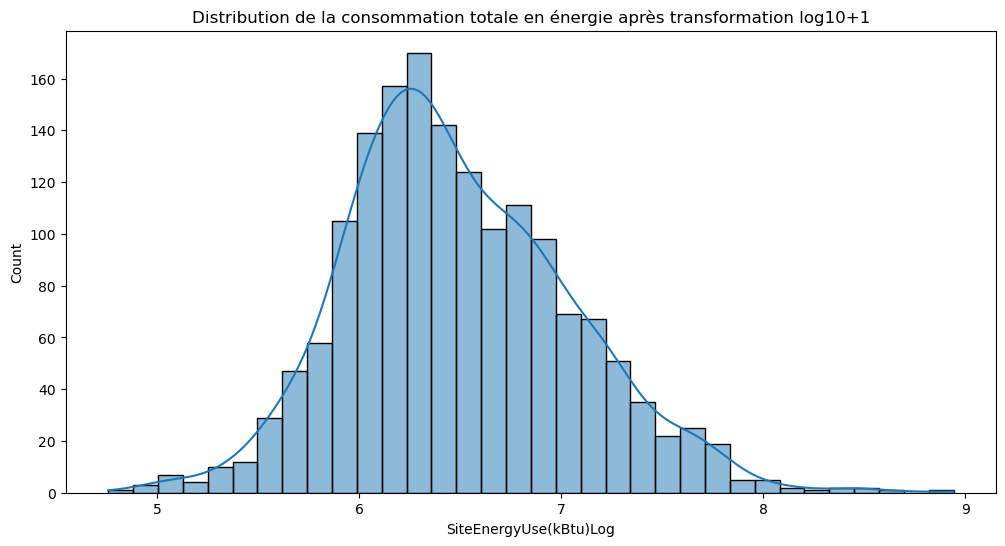

In [96]:
plt.figure(figsize = (12,6))
sns.histplot(data=df, x="SiteEnergyUse(kBtu)Log", kde=True)
plt.title("Distribution de la consommation totale en énergie après transformation log10+1")
plt.show()

on fait  une analyse bivariée des target entres elles

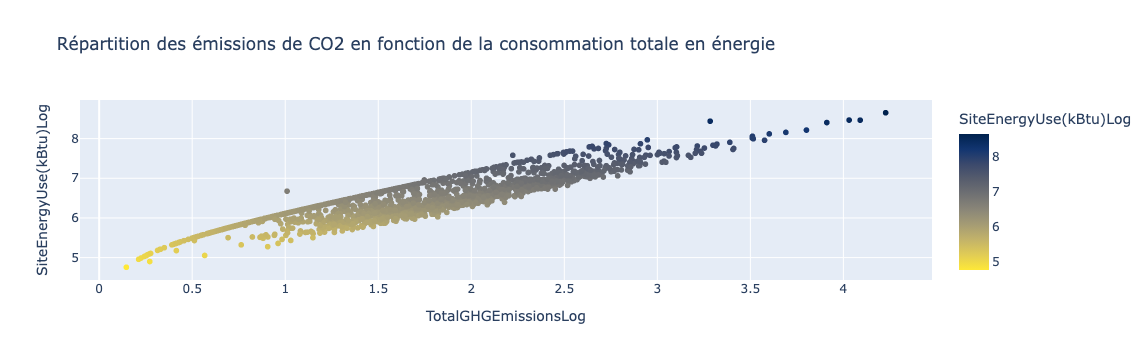

In [185]:
fig = px.scatter(df,
                 x="TotalGHGEmissionsLog",
                 y="SiteEnergyUse(kBtu)Log",
                 title = "Répartition des émissions de CO2 en fonction de la consommation totale en énergie",
                 color = "SiteEnergyUse(kBtu)Log",
                color_continuous_scale=px.colors.sequential.Cividis_r)
fig.show()

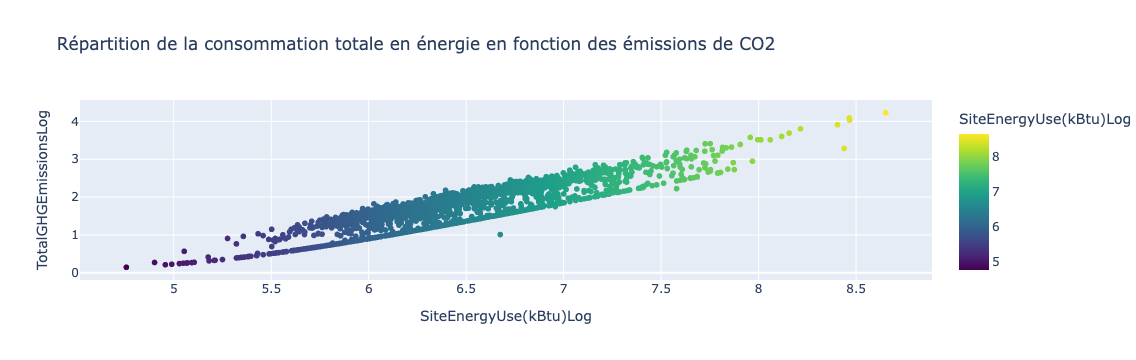

In [186]:
fig = px.scatter(df,
                 y="TotalGHGEmissionsLog",
                 x="SiteEnergyUse(kBtu)Log",
                 title = "Répartition de la consommation totale en énergie en fonction des émissions de CO2",
                 color = "SiteEnergyUse(kBtu)Log",
                color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

### Analyse multivariée

In [97]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'ParkingRatio', 'BuildingRatio',
       'FloorsRatio', 'BuildingsRatio', 'LargestUseTypeRatio',
       'SecondLargestUseTypeRatio', 'ThirdLargestUseTypeRatio',
       'NumberOfAllUseTypes', 'distance_from_center', 'TotalGHGEmissionsLog',
       'SiteEnergyUse(kBtu)Log'],
      dtype='object')

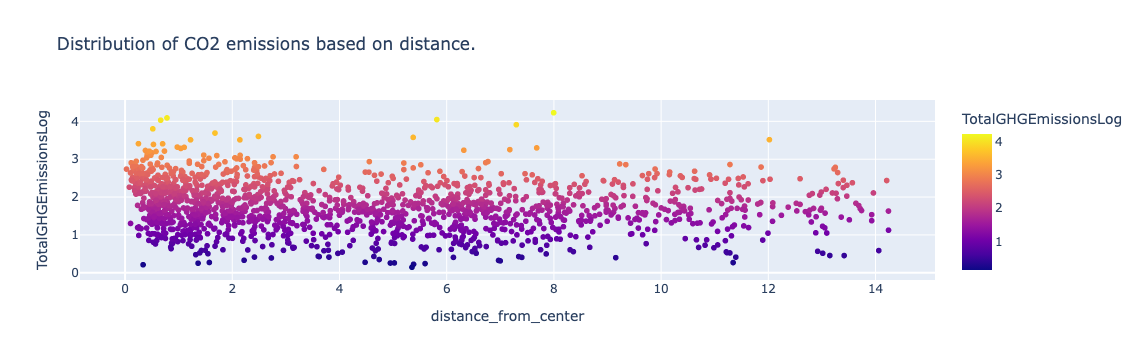

In [ ]:
scatter_plot = px.scatter(data_frame=df, x="distance_from_center", y="TotalGHGEmissionsLog",
                          color="TotalGHGEmissionsLog",
                          title="Distribution of CO2 emissions based on distance.")
scatter_plot.show()

## Exportation pour modélisation :

In [100]:
df.drop(columns=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"], inplace = True)

In [105]:
df.to_csv("df_cleaned.csv")

In [106]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Neighborhood',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'BuildingAge', 'ParkingRatio',
       'BuildingRatio', 'FloorsRatio', 'BuildingsRatio', 'LargestUseTypeRatio',
       'SecondLargestUseTypeRatio', 'ThirdLargestUseTypeRatio',
       'NumberOfAllUseTypes', 'distance_from_center', 'TotalGHGEmissionsLog',
       'SiteEnergyUse(kBtu)Log'],
      dtype='object')